# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

# imports

In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib as mpl
import cv2
import itertools
import six

import pickle
import utils
import tensorflow as tf
from tensorflow.contrib.layers import flatten, l2_regularizer, conv2d, max_pool2d, dropout, fully_connected
from tensorflow.python.client import device_lib
from sklearn.utils import shuffle
import pandas as pd

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


font = {'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)
mpl.rcParams['text.color'] = 'g'
get_available_gpus()

override = False

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


---
## Step 0: Load The Data

In [2]:
training_file = '../traffic-signs-data/train.p'
validation_file= '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
postprocessed = False



file_list = [os.path.join('web_images', name) for name in os.listdir("web_images/")]
image_list = [f for f in file_list if os.path.splitext(f)[-1] in ['.jpg', '.png', '.jpeg']]
y_web = np.array([int(os.path.split(name)[-1].split("_")[0]) for name in image_list])
X_web_orig = [cv2.cvtColor(cv2.imread(name), cv2.COLOR_RGB2BGR) for name in image_list]
X_web_resized = list(map(lambda image: cv2.resize(image, (32,32)), X_web_orig))


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of validation examples
n_valid = y_valid.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)

print("Number of validation examples =", n_valid)

print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

### Data exploration visualization code goes here.

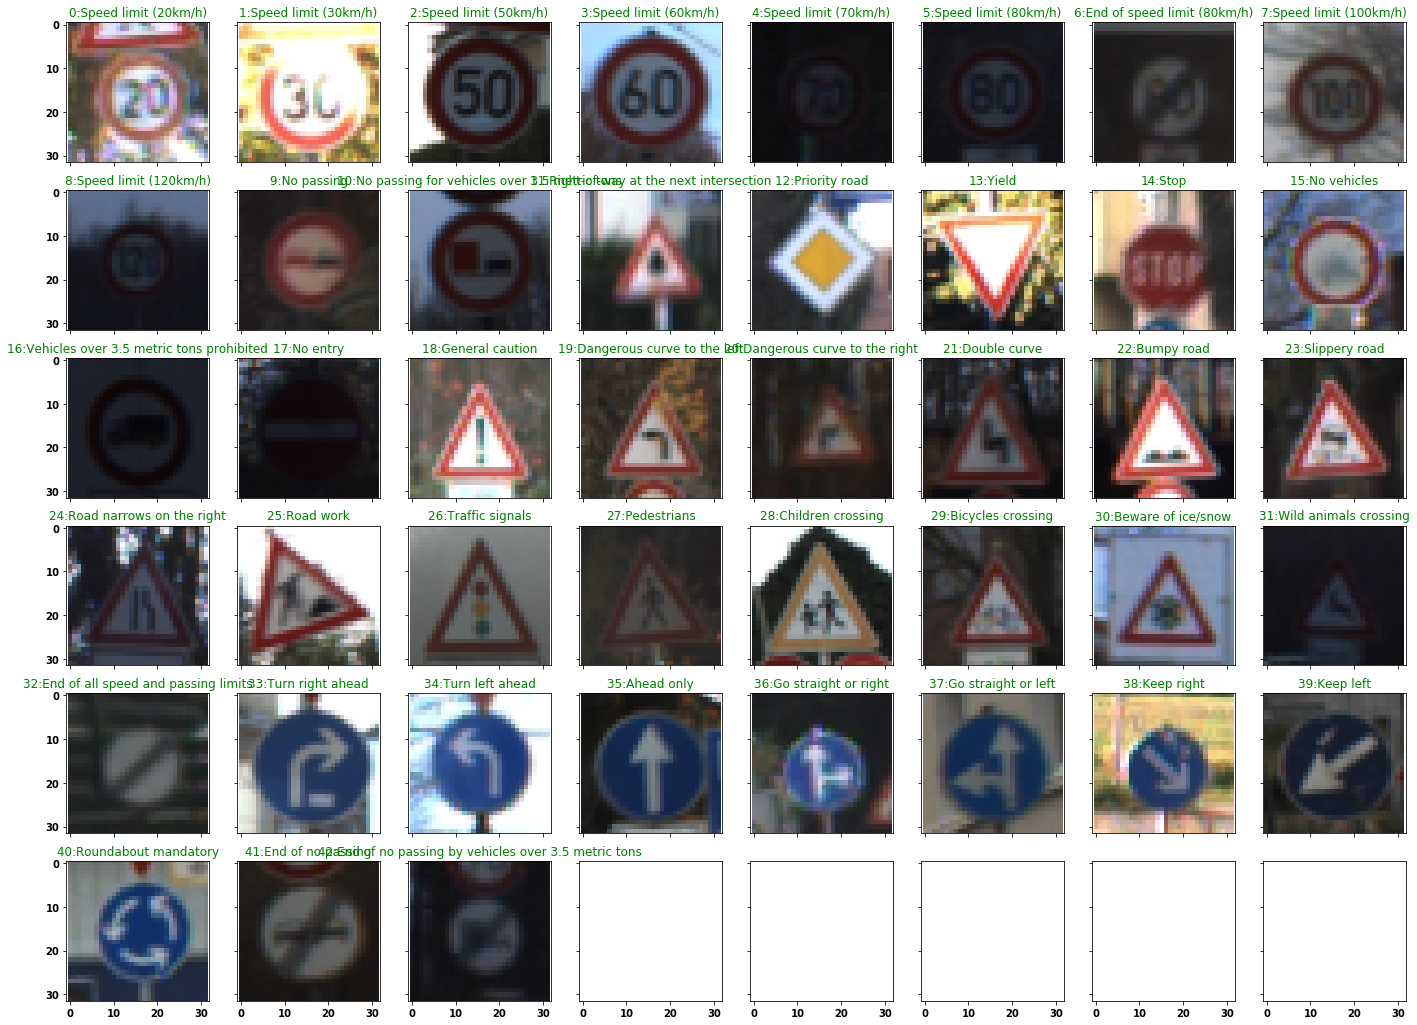

In [4]:

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
#X_train[0]
# def setup_figure(m_pics, w, h, n=10):
#     return plt.subplots(1, m_pics, squeeze=True, sharex=True, sharey=True, figsize=(m_pics * n, h / w * n))        
#utils.setup_figure(1, )
#plt.imshow(X_train)
assert len(set([x.shape for x in X_train])) == 1
signnames = pd.read_csv("signnames.csv", index_col='ClassId')


h, w = X_train[0].shape[:2]
n = 3
nx = 8
ny = int(np.ceil(len(set(y_train)) / nx))
fig, ax = utils.setup_figure(x_pics=nx, y_pics=ny, w=w, h=h, n=n)

visited = set()
for isample in sorted((set(y_train))):
    ix = isample % nx
    iy = int((isample - ix) / nx)
    ind = np.where(y_train == isample)[0]
    ind = ind[np.random.randint(len(ind))]
    
    x = X_train[ind]
    ax[iy][ix].imshow(x)
    ax[iy][ix].set_title("{}:{}".format(isample, signnames.loc[isample, "SignName"]), fontsize=12, color='g')

plt.savefig('output_images/1_raw_samples.png', bbox_inches='tight')
    
flipleft_to_right = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
flip_up_down = [1, 5, 12, 15, 17]
flip_ud_lr = [15, 17, 32, 40]
pairs_flip_lr = {19:20, 20:19, 33: 34, 34:33, 37:36, 36:37, 39:38, 38:39}

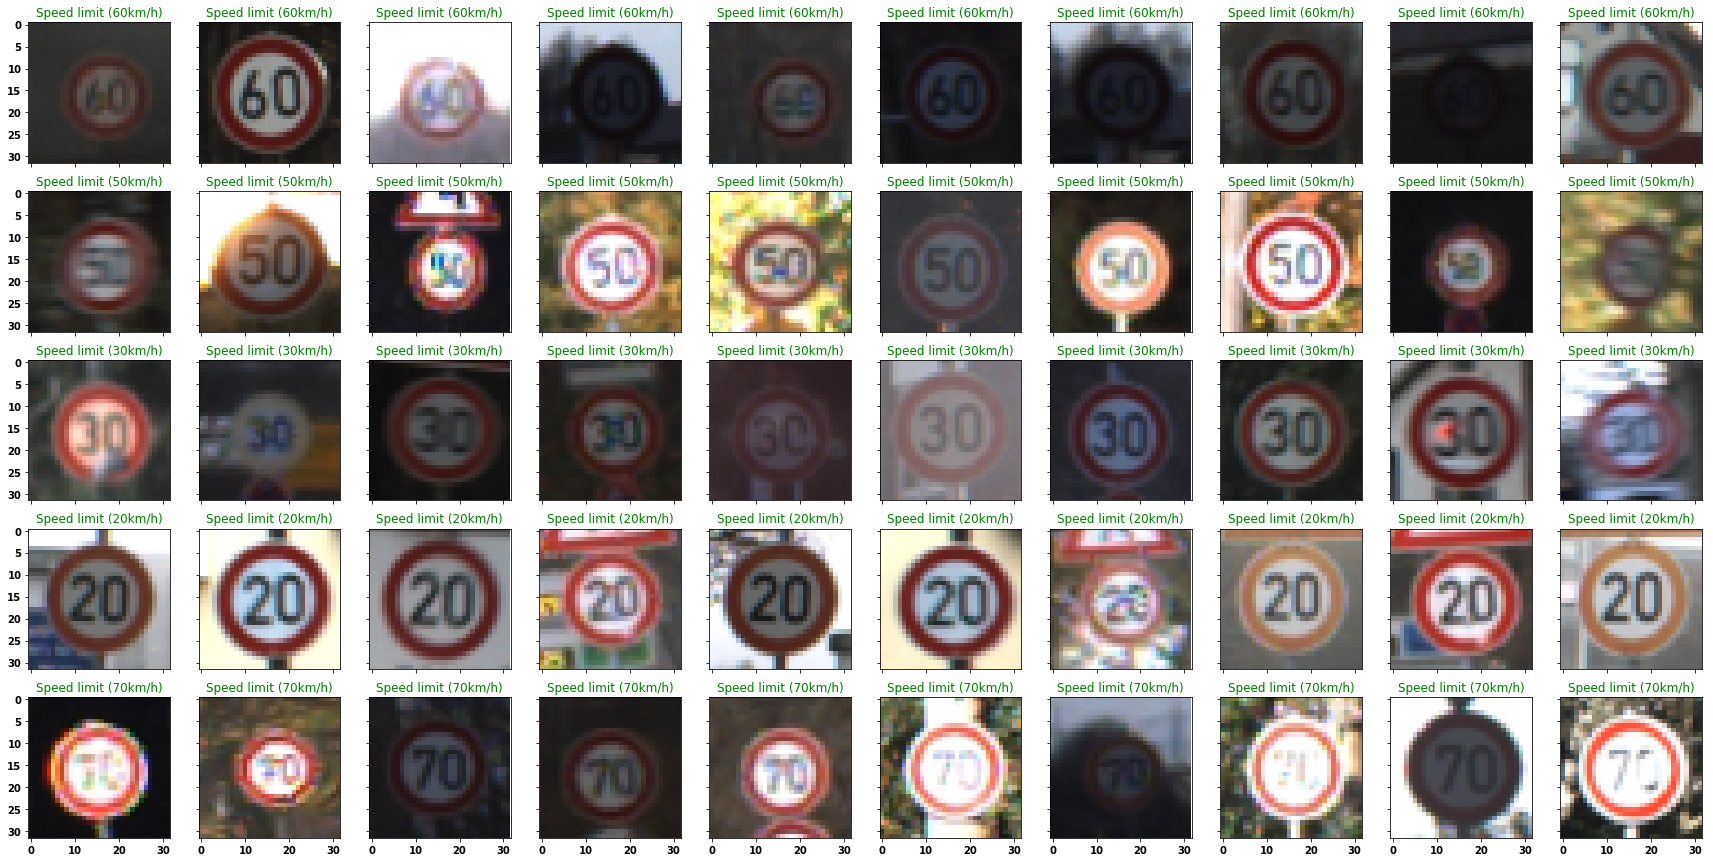

In [5]:
#X_train[0]
# def setup_figure(m_pics, w, h, n=10):
#     return plt.subplots(1, m_pics, squeeze=True, sharex=True, sharey=True, figsize=(m_pics * n, h / w * n))        
#utils.setup_figure(1, )
#plt.imshow(X_train)
assert len(set([x.shape for x in X_train])) == 1

figname = 'output_images/1_raw_images.png'
if os.path.exists(figname) and False:
    image = cv2.imread(figname)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    plt.figure(figsize=(20,20))
    plt.imshow(image)
    
    with open('cache/display_images.pkl', 'rb') as fd:
        display_images = pickle.load(fd)
    
else:
    h, w = X_train[0].shape[:2]
    # fig, ax = utils.setup_figure(x_pics=5, y_pics=2, w=w, h=h)
    n = 3
    nx = 10
    ny = 5
    # fit, ax = plt.subplots(ny, nx, squeeze=True, sharex=True, sharey=True, figsize=(nx * n, ny * n))#h / w * n))


    fig, ax = utils.setup_figure(x_pics=nx, y_pics=ny, w=w, h=h, n=3)


    display_images = []
    visited = set()
    for iy in range(ny):
        j = np.random.randint(ny)
        while j in visited:
            j = np.random.randint(ny)
        visited.add(j)
        image_list_iy = []

        ind = np.where(y_train == j)[0]
        for i in range(nx):
            ix = np.random.randint(len(ind))
            ax[iy][i].imshow(X_train[ind[ix]])
            
            ax[iy][i].set_title(signnames.loc[j, "SignName"], fontsize=12, color='g')

            image_list_iy.append(ind[ix])
        display_images.append(image_list_iy)

    plt.savefig('output_images/1_raw_images.png', bbox_inches='tight')
    with open('cache/display_images.pkl', 'wb') as fd:
        pickle.dump(display_images, fd)

    # fig, ax = utils.setup_figure(x_pics=len(display_images[0]), y_pics=len(display_images), w=w, h=h, n=3)
    # for iy, disp in enumerate(display_images):
    #     for ix, index in enumerate(disp):
    #          ax[iy][ix].imshow(X_train[index])


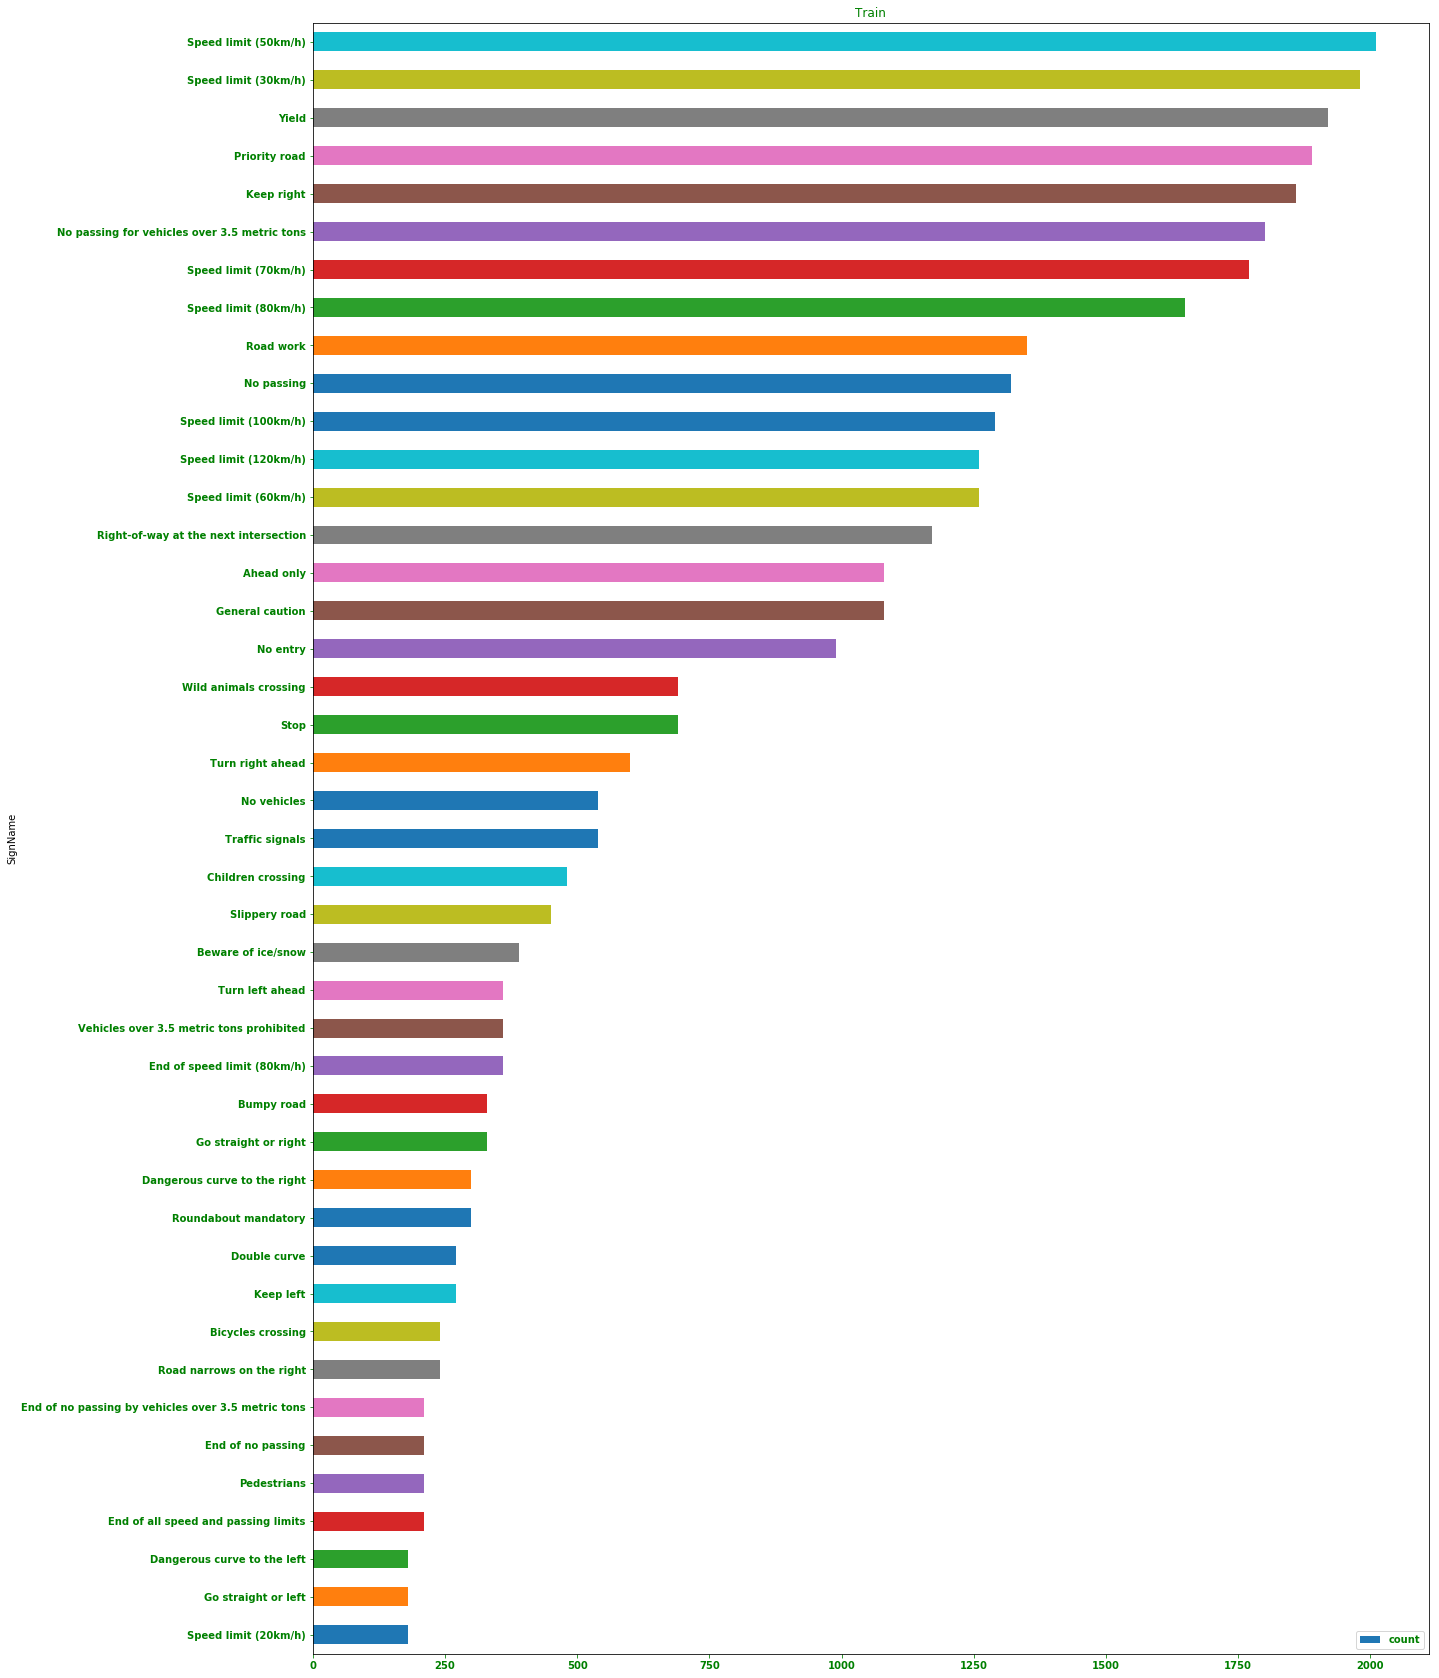

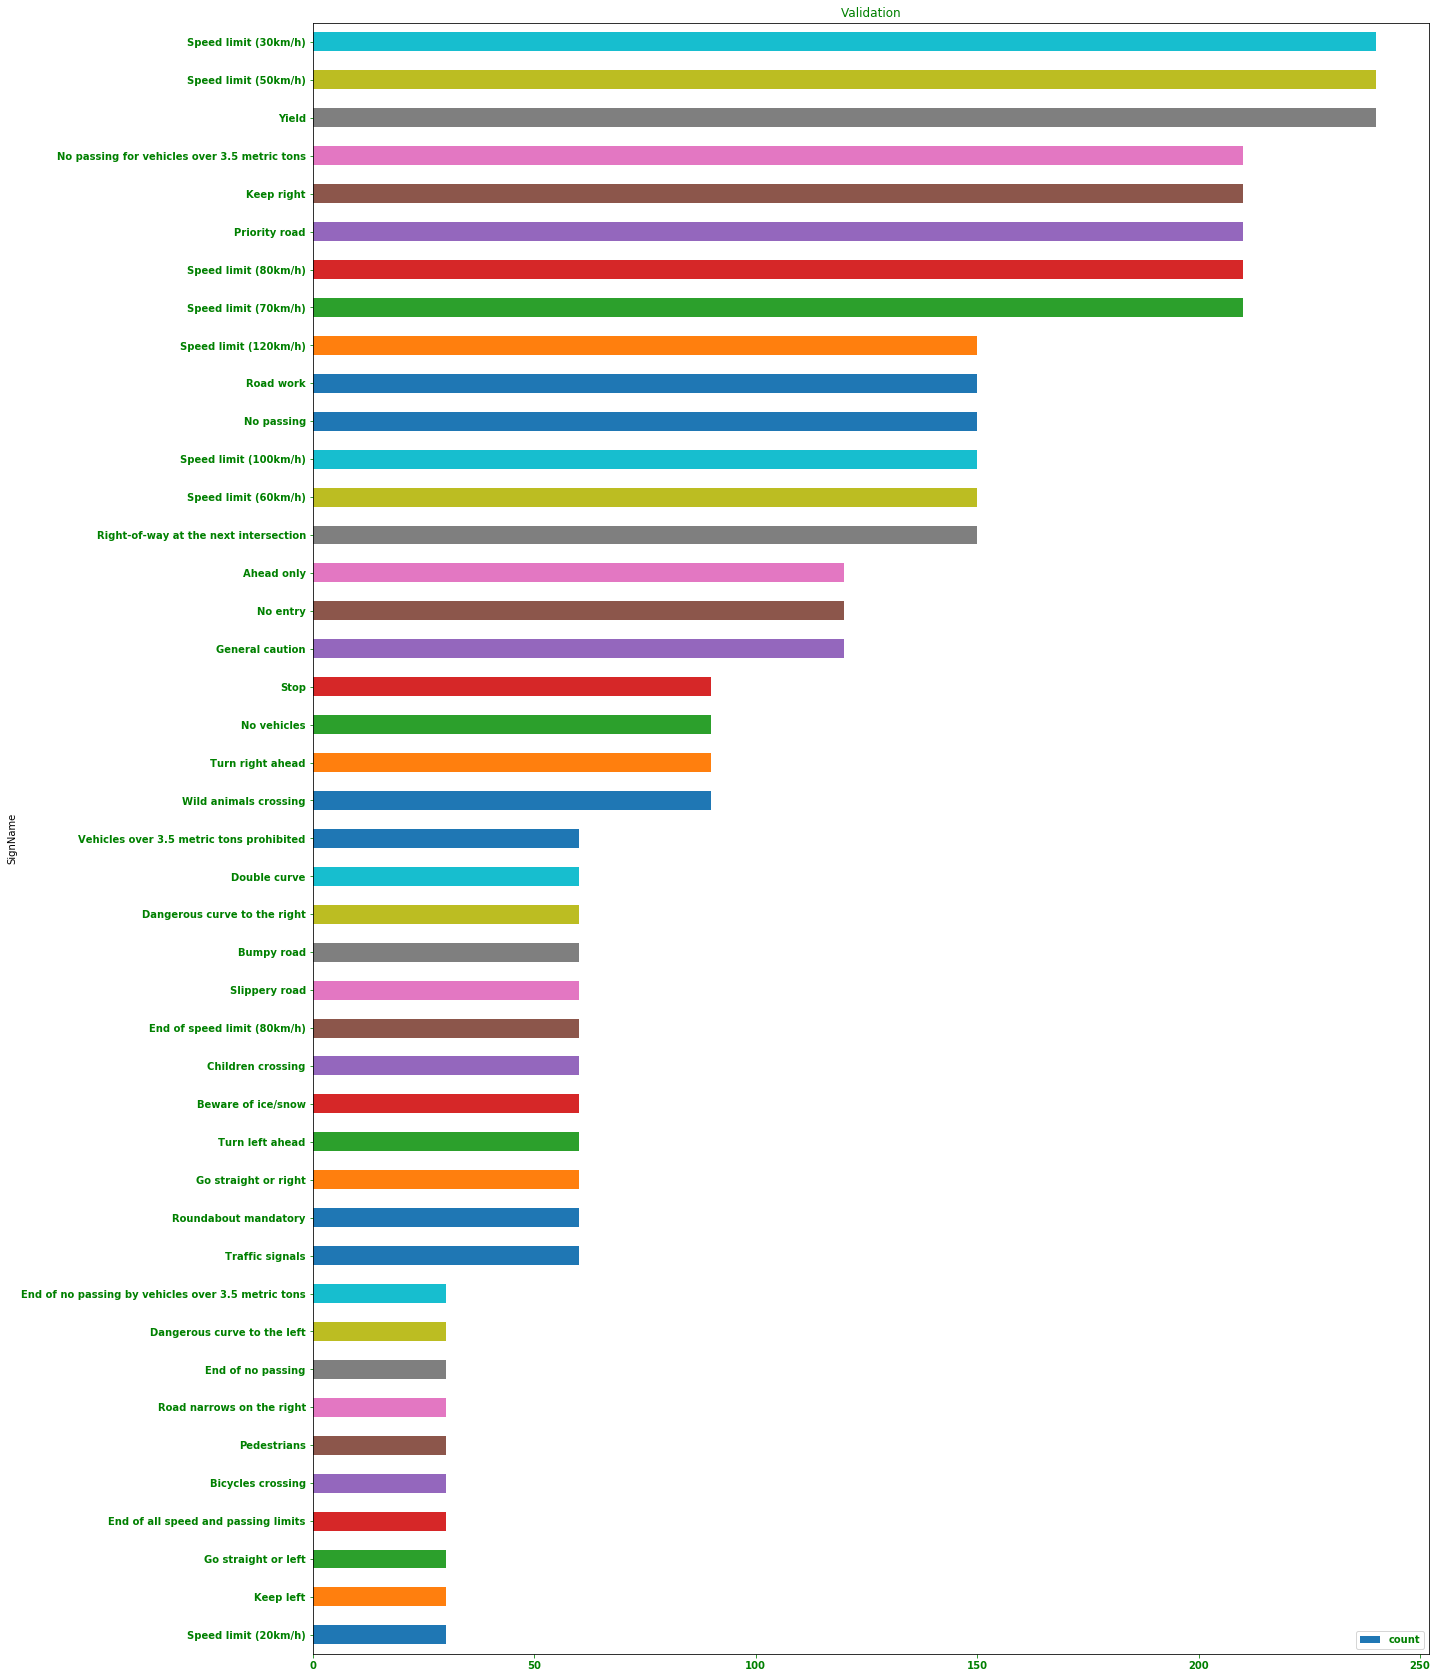

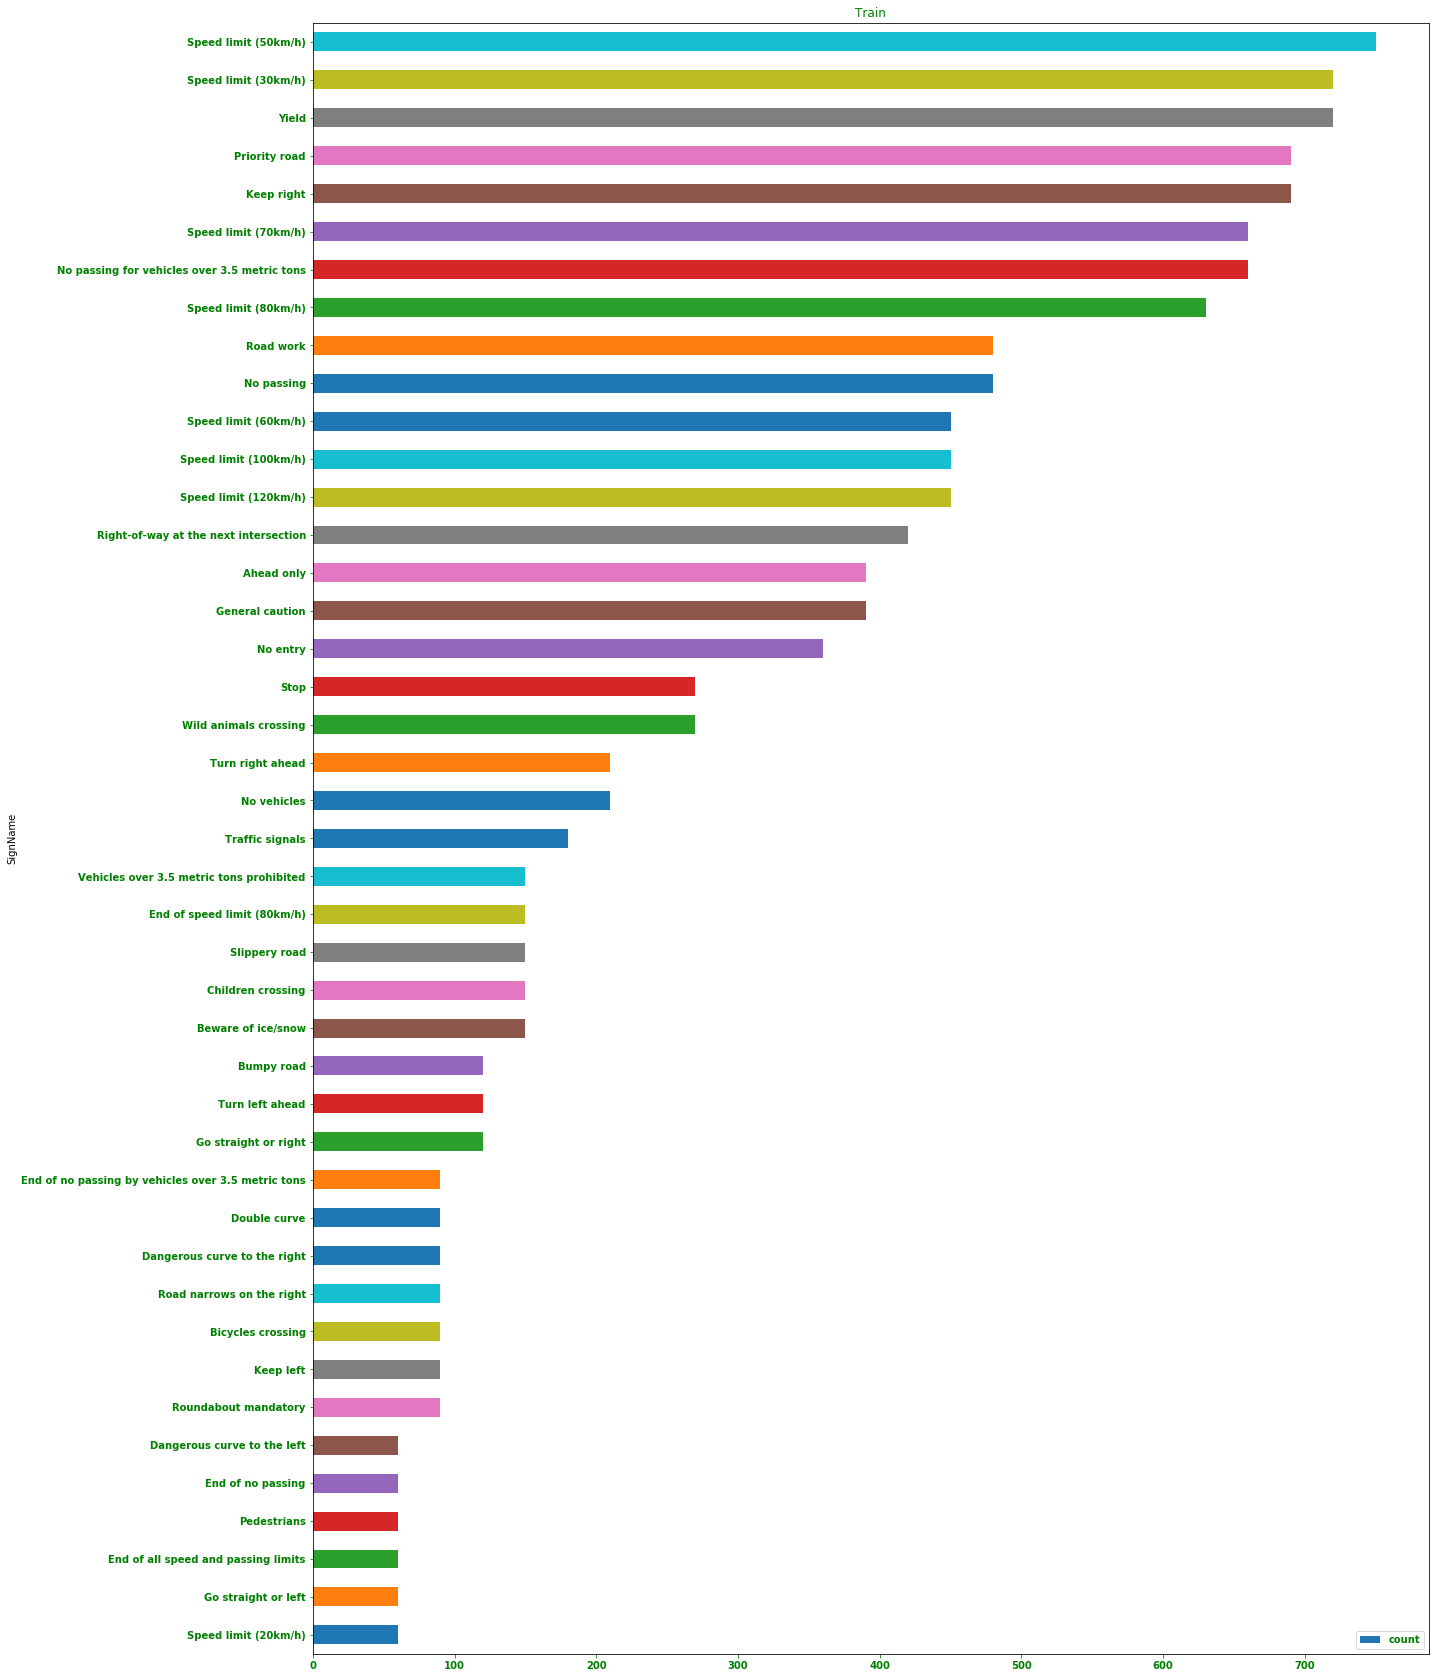

In [6]:
# Train
sign_count_train = signnames.copy()
sign_count_train.loc[:, "count"] = pd.Series(y_train).value_counts().sort_index()
sign_count_train = sign_count_train.sort_values(by='count', ascending=True)
sign_count_train.plot.barh(x='SignName', y='count', figsize=(20,30), title='Train')
ax = plt.gca()
ax.tick_params(axis='y', colors='g')
ax.tick_params(axis='x', colors='g')
plt.savefig('output_images/1_train_ordered_hist.png', bbox_inches='tight')

# Validation
sign_count_valid = signnames.copy()
sign_count_valid.loc[:, "count"] = pd.Series(y_valid).value_counts().sort_index()
sign_count_valid = sign_count_valid.sort_values(by='count', ascending=True)
sign_count_valid.plot.barh(x='SignName', y='count', figsize=(20,30), title='Validation')
ax = plt.gca()
ax.tick_params(axis='y', colors='g')
ax.tick_params(axis='x', colors='g')
plt.savefig('output_images/1_valid_ordered_hist.png', bbox_inches='tight')


# Test
sign_count_test = signnames.copy()
sign_count_test.loc[:, "count"] = pd.Series(y_test).value_counts().sort_index()
sign_count_test = sign_count_test.sort_values(by='count', ascending=True)
sign_count_test.plot.barh(x='SignName', y='count', figsize=(20,30), title='Train')
ax = plt.gca()
ax.tick_params(axis='y', colors='g')
ax.tick_params(axis='x', colors='g')
plt.savefig('output_images/1_test_ordered_hist.png', bbox_inches='tight')



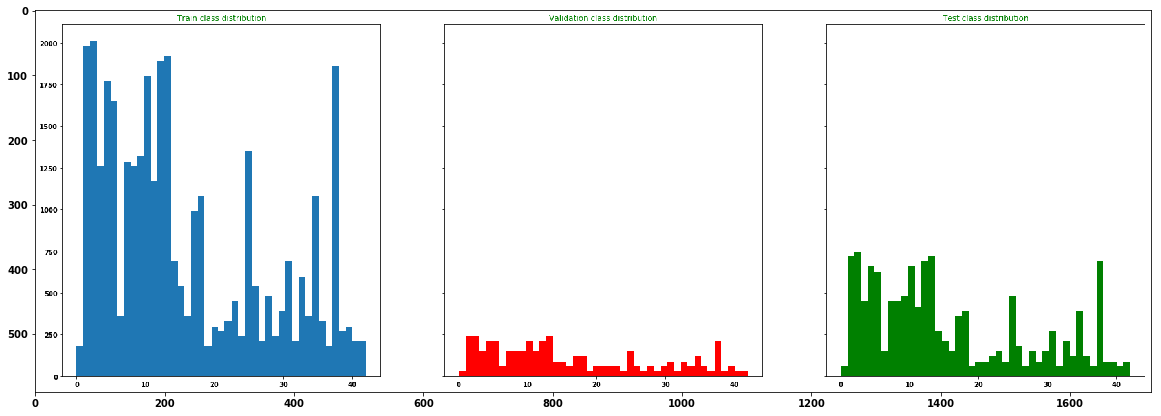

In [7]:
# distribution
#fig, ax = utils.setup_figure(x_pics=3, y_pics=1, w=w, h=h, n=3)
figname = 'output_images/1_classes_distribution.png'
if os.path.exists(figname):
    image = cv2.imread(figname)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    plt.figure(figsize=(20,20))
    plt.imshow(image)
else:  
    fig, ax = plt.subplots(1, 3, squeeze=True, sharex=True, sharey=True, figsize=(30, 10))

    ax[0].hist(y_train, bins = len(set(y_train)))
    ax[0].set_title("Train class distribution", color='g')

    ax[1].hist(y_valid, bins = len(set(y_train)), color='r')
    ax[1].set_title("Validation class distribution", color='g')

    ax[2].hist(y_test, bins = len(set(y_train)), color='g')
    ax[2].set_title("Test class distribution", color='g')

    plt.savefig(figname, bbox_inches='tight')



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

### Preprocessing class

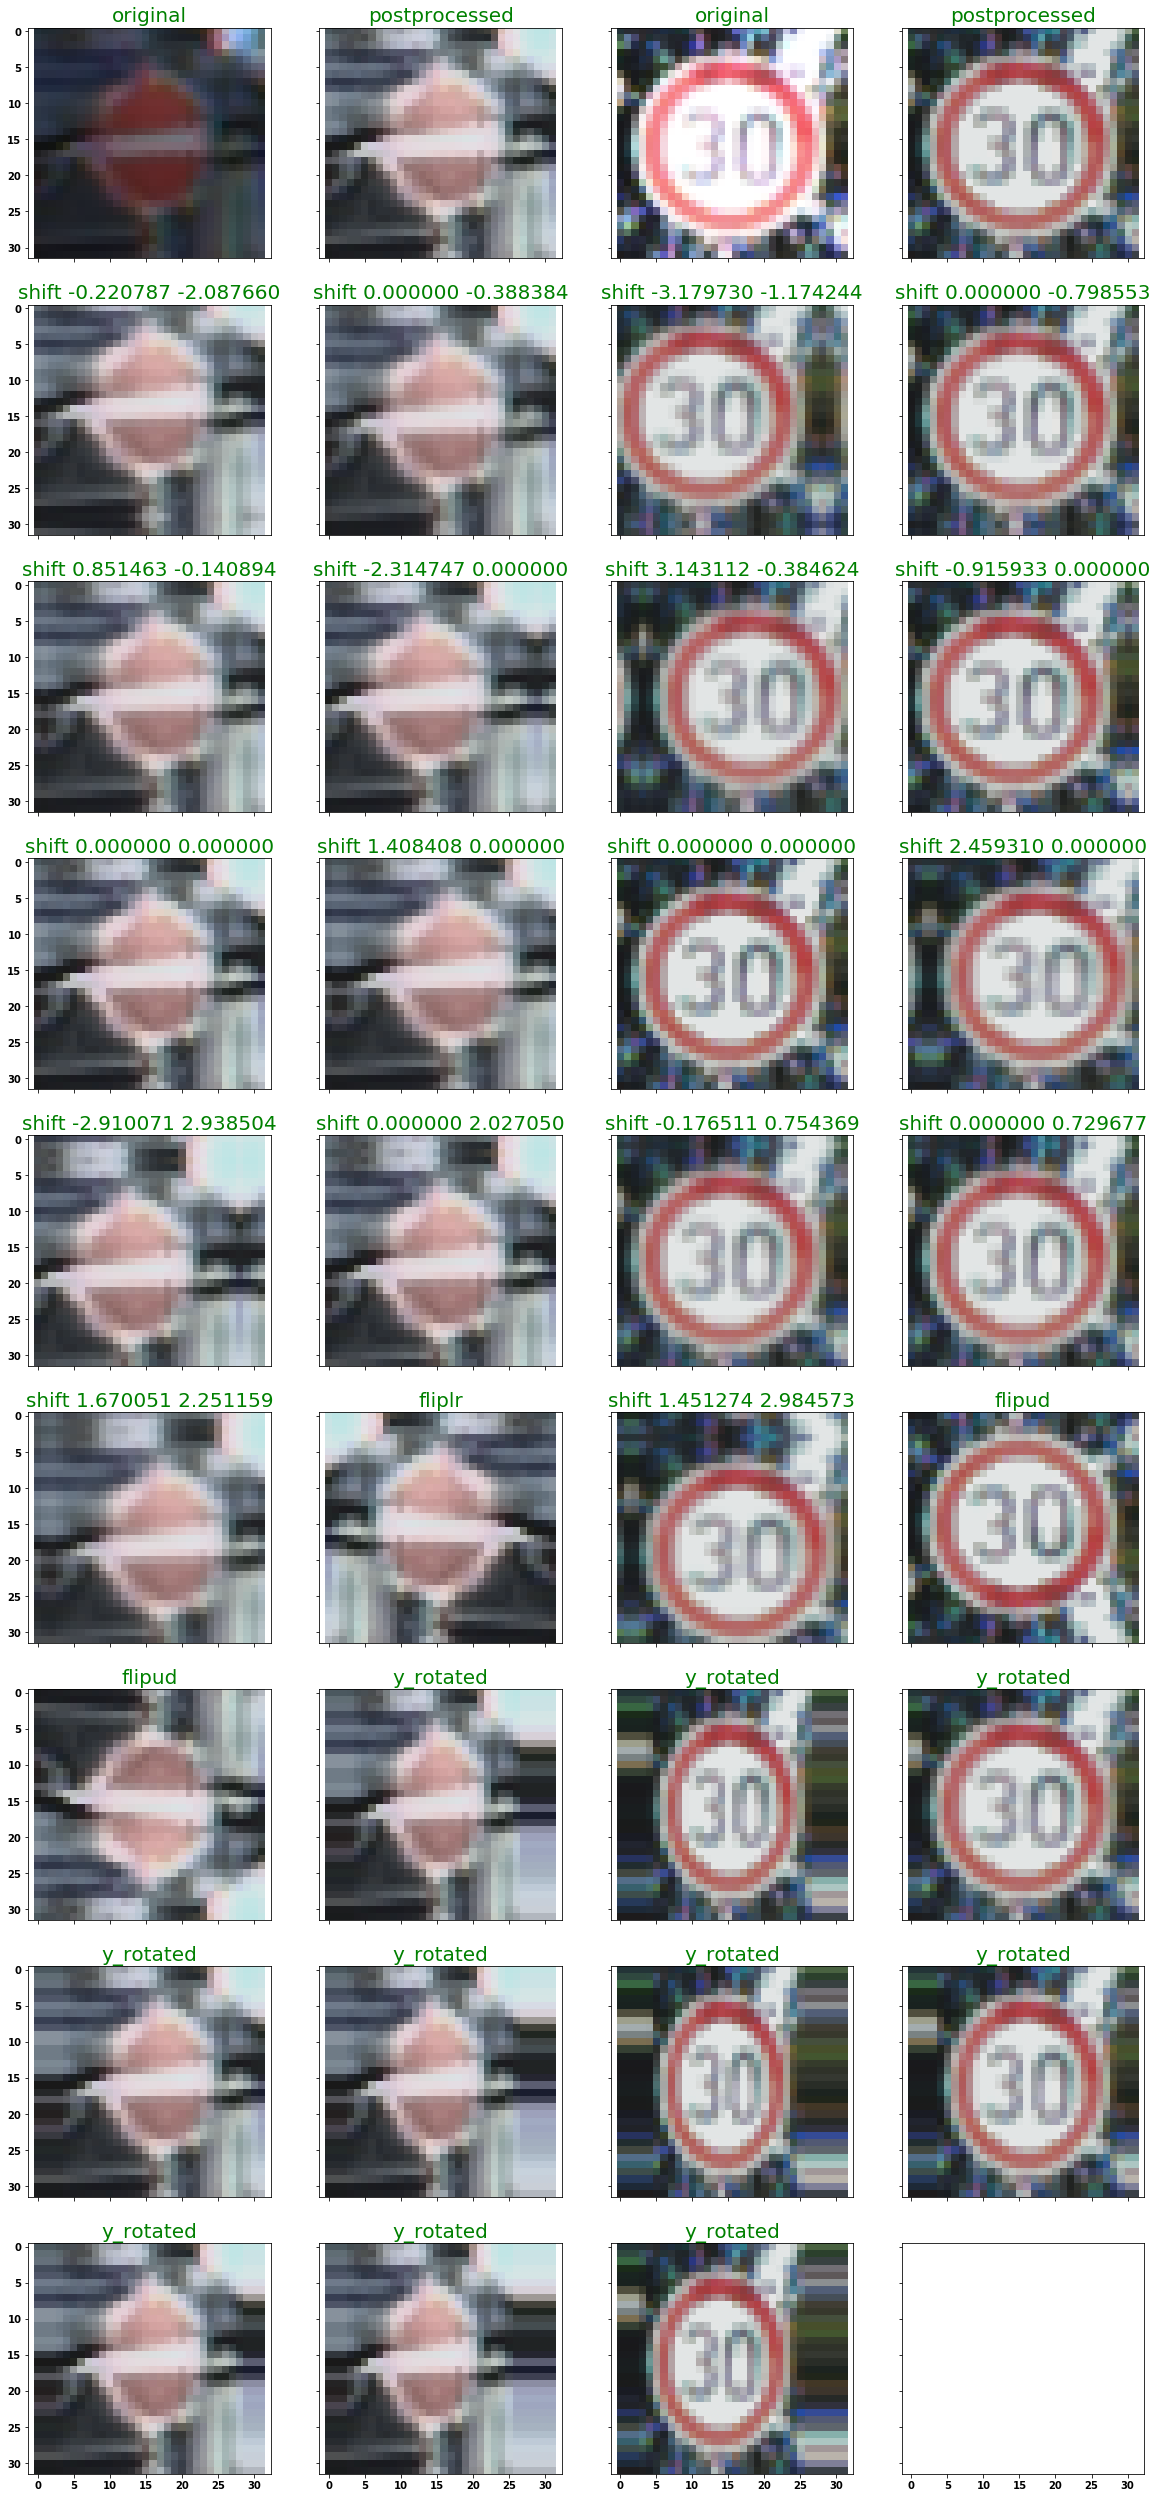

In [9]:
flip_lr = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
flip_ud = [1, 5, 12, 15, 17]
flip_ud_and_lr = [32, 40]
pairs_flip_lr = {19:20, 20:19, 33: 34, 34:33, 37:36, 36:37, 39:38, 38:39}

class PreprocessingPipeline(object):
    
    def __init__(self, augment=True):
        self.augment = augment
        self.flip_lr = flip_lr
        self.flip_ud = flip_ud
        self.flip_ud_and_lr = flip_ud_and_lr
        self.pairs_flip_lr = pairs_flip_lr
    
    @staticmethod
    def whiteBalance(image):
        # https://pippin.gimp.org/image-processing/chapter-automaticadjustments.html
        lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        avg_a = np.average(lab_image[:, :, 1])
        avg_b = np.average(lab_image[:, :, 2])
        L = lab_image[:,:,0] / 255.
        lab_image[:, :, 1] = lab_image[:, :, 1] - (np.average(lab_image[:, :, 1]) - 128) * L * 1.1
        lab_image[:, :, 2] = lab_image[:, :, 2] - (np.average(lab_image[:, :, 2]) - 128) * L * 1.1
        image_out = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

        image[:] = image_out

    @staticmethod
    def equalizeHist(gray):
        #         image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        #         image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
        #         image[:] = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
        gray[:] = cv2.equalizeHist(gray)

    @staticmethod
    def equalizeRGBHist(image):
        image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
        return cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)

    @staticmethod
    def rgb2gray(image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    @staticmethod
    def normalize(gray):
        #gray[:] = cv2.normalize(src=gray, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        gray = (gray - gray.min()) / (gray.max() - gray.min())


    @staticmethod
    def normalizeRGB(image):
        #gray[:] = cv2.normalize(src=gray, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        # image[:] = 0.1 + (0.9 - 0.1) * (image - image.min()) / (image.max() - image.min())
        r, g, b = cv2.split(image)
        r = cv2.normalize(r, None, alpha=0.1, beta=0.9, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        g = cv2.normalize(g, None, alpha=0.1, beta=0.9, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        b = cv2.normalize(b, None, alpha=0.1, beta=0.9, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return cv2.merge([r, g, b])

    @staticmethod
    def fliplr(image):
        return cv2.flip(image, 1)

    @staticmethod
    def flipud(image):
        return cv2.flip(image, 0)

    @staticmethod
    def shift(image, tx, ty):
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    @staticmethod
    def rotate_around_y(image):
        rows, cols = image.shape[:2]
        w = 0.2
        nleft = w * np.random.rand(1) * cols
        nright = ((1-w) + w * np.random.rand(1)) * cols
        pts1 = np.float32([[0,0],[cols, 0],[0, rows],[cols, rows]])
        pts2 = np.float32([[nleft, 0],[nright, 0],[nleft, rows],[nright, rows]])
        M = cv2.getPerspectiveTransform(pts1, pts2)
        
        return cv2.warpPerspective(image, M, (cols, cols), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
        
    def run(self, image, image_class=None):

        _image = image.copy()
        self.whiteBalance(_image)
        _image = self.equalizeRGBHist(_image)
        _image = self.normalizeRGB(_image)
        
#        gray = self.rgb2gray(image_)
#        self.normalize(gray)
#         self.equalizeHist(gray)
        
#         out = gray
        out = _image
        
        if self.augment and image_class is not None:
            
            shift_only_orig = True
            augments = []
            
            ## shifts
            if shift_only_orig:
                shift = [-1, 0, 1]
                for ys, xs in itertools.product(shift, shift):
                    #                     if np.random.rand(1) > 0.5:
                    #                         continue
                    yshift = ys * np.random.rand(1) * 0.1 * image.shape[0]
                    xshift = xs * np.random.rand(1) * 0.1 * image.shape[1]
                    augments.append((image_class, self.shift(out, xshift, yshift), "shift %f %f" % (xshift, yshift)))
            
            # can do the following for every one of the shifted ...
            ## flips
            if image_class in self.flip_lr:
                augments.append((image_class, self.fliplr(out), "fliplr"))

            if image_class in self.flip_ud:
                augments.append((image_class, self.flipud(out), "flipud"))

            if image_class in self.flip_ud_and_lr:
                augments.append((image_class, self.fliplr(self.flipud(out)), "fliplr+flipud"))

            if image_class in self.pairs_flip_lr:
                augments.append((self.pairs_flip_lr[image_class], self.fliplr(out), "fliplr + class change"))
            
            # run ~ 3 rotation about y
            for i in range(5):
                augments.append((image_class, self.rotate_around_y(out), "y_rotated"))

            ## shifts                
            if False:
                shift_augments = []
                shift = [-1, 0, 1]
                for (image_class, aug_image, name) in augments:
                    for ys, xs in itertools.product(shift, shift):
                        yshift = ys * np.random.rand(1) * 0.1 * aug_image.shape[0]
                        xshift = xs * np.random.rand(1) * 0.1 * aug_image.shape[1]
                        shift_augments.append((image_class, self.shift(aug_image, xshift, yshift), name + " + shift %f %f" % (xshift, yshift)))

                for ys, xs in itertools.product(shift, shift):
                    yshift = ys * np.random.rand(1) * 0.1 * image.shape[0]
                    xshift = xs * np.random.rand(1) * 0.1 * image.shape[1]
                    shift_augments.append((image_class, self.shift(out, xshift, yshift), "shift %f %f" % (xshift, yshift)))
                
                augments += shift_augments
                
                
#             return gray, augments
            return _image, augments

#         return gray
        return _image
    
#index = np.random.randint(len(X_train))
#index = np.where(y_train == 17)[0]
index = np.where(y_train == 17)[0]
index = index[np.random.randint(len(index))]
image = X_train[index]
image_class = y_train[index]

preprocessor = PreprocessingPipeline()
out, augments = preprocessor.run(image, image_class)

ny = int(np.ceil(len(augments) / 2 + 1))
nx = 4

fig, ax = utils.setup_figure(x_pics=nx, y_pics=ny, w=w, h=h, n=5)

ax[0][0].imshow(image)
ax[0][0].set_title("original", color='g', fontsize=20)
ax[0][1].imshow(out, cmap='gray')
ax[0][1].set_title("postprocessed", color='g', fontsize=20)

for i in range(0, len(augments)):
    ix = i % (nx - 2)
    iy = 1 + int((i - ix) / (nx - 2))
    ax[iy][ix].imshow(augments[i][1], cmap='gray')
    ax[iy][ix].set_title(augments[i][2], color='g', fontsize=20)

# 2nd example
index = np.where(y_train == 1)[0]
index = index[np.random.randint(len(index))]
image = X_train[index]
image_class = y_train[index]
out, augments = preprocessor.run(image, image_class)


ax[0][2].imshow(image)
ax[0][2].set_title("original", color='g', fontsize=20)
ax[0][3].imshow(out, cmap='gray')
ax[0][3].set_title("postprocessed", color='g', fontsize=20)

for i in range(0, len(augments)):
    ix = i % (nx - 2)
    iy = 1 + int((i - ix) / (nx - 2))
    ax[iy][ix + 2].imshow(augments[i][1], cmap='gray')
    ax[iy][ix + 2].set_title(augments[i][2], color='g', fontsize=20)

    
    
# index = np.random.randint(len(X_train))

# index = index[np.random.randint(len(index))]


# flipleft_to_right = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
# flip_up_down = [5, 12, 15, 17]
# flip_ud_lr = [32, 40]
# pairs_flip_lr = {19:20, 20:19, 33: 34, 34:33, 37:36, 36:37, 39:38, 38:39}

figname = "output_images/2_rgb_and_postprocessing.png"
plt.savefig(figname)

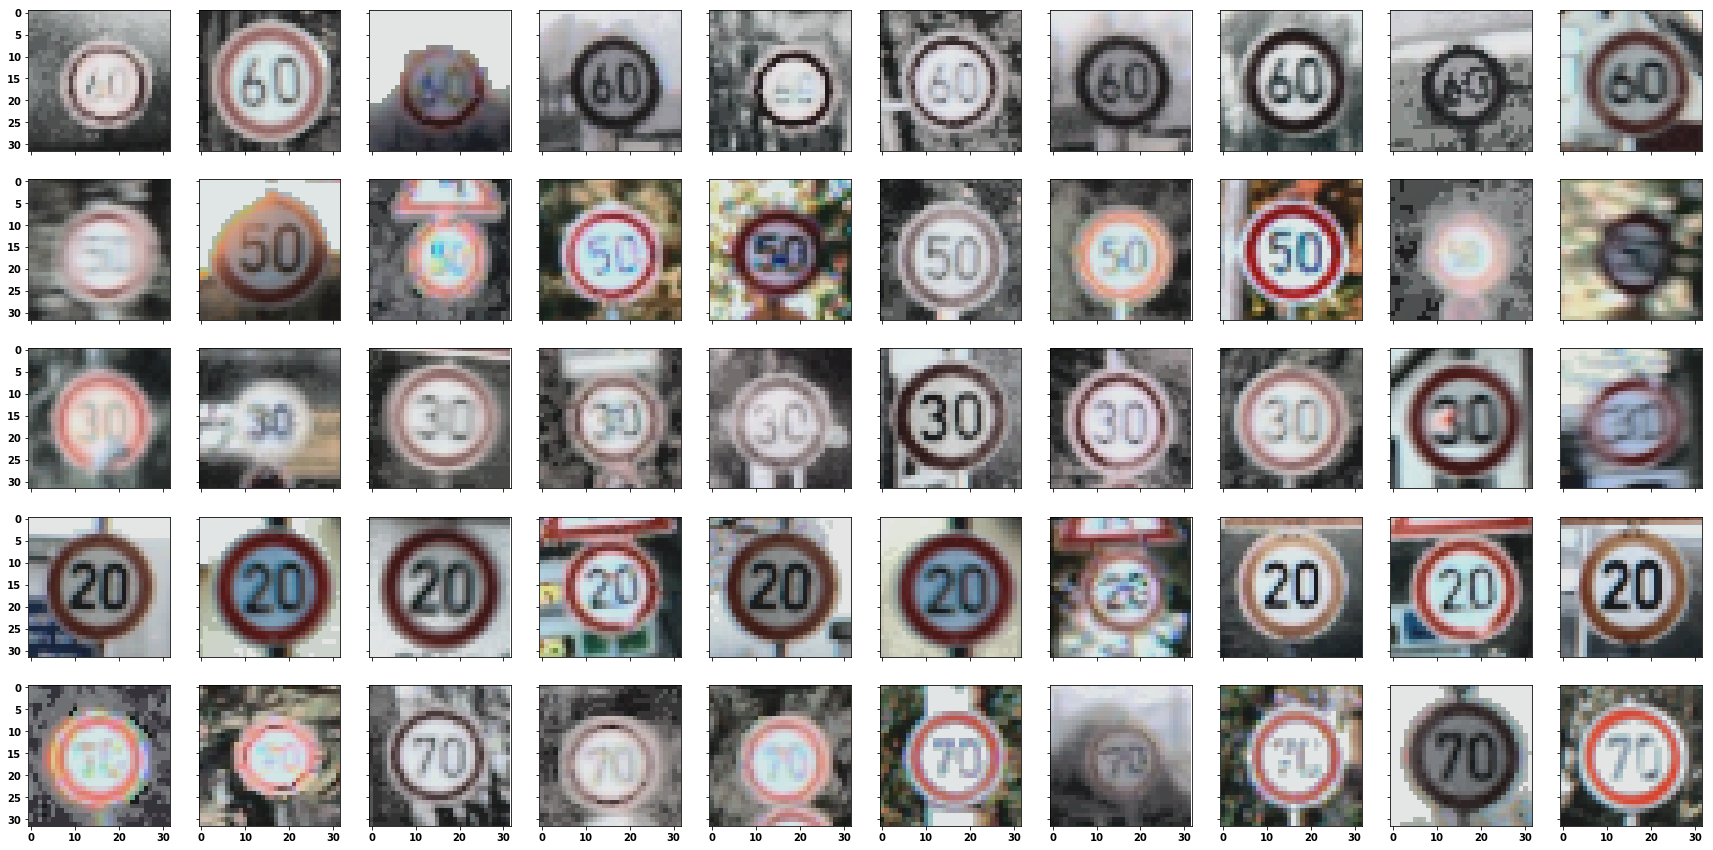

In [10]:
figname = "output_images/2_postprocessing.png"
preprocessor = PreprocessingPipeline()

# distribution
#fig, ax = utils.setup_figure(x_pics=3, y_pics=1, w=w, h=h, n=3)
if os.path.exists(figname) and False:
    image = cv2.imread(figname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20,20))
    plt.imshow(image, cmap='gray')
    
else:
    fig, ax = utils.setup_figure(x_pics=len(display_images[0]), y_pics=len(display_images), w=w, h=h, n=3)
    for iy, disp in enumerate(display_images):
        for ix, index in enumerate(disp):
            out = preprocessor.run(X_train[index])

            #ax[iy][ix].imshow(out, cmap='gray')
            ax[iy][ix].imshow(out)
    else:
        plt.savefig(figname)


## preprocess dataset



In [11]:
augment = True
preprocessor = PreprocessingPipeline(augment=augment)
cached_x = "cache/X_postprocessed.pkl"
if not postprocessed and not os.path.exists(cached_x):
    
    processed = list(map(preprocessor.run, X_train, y_train))
    if augment:
        x_train = [p[0] for p in processed]
        augments = [p[1] for p in processed]

        x_train_aug = []
        y_train_aug = []
        for i, examples in enumerate(augments):
            for example in examples:
                y_train_aug.append(example[0])
                x_train_aug.append(example[1])

        #X_train = np.expand_dims(np.concatenate([x_train, x_train_aug]), axis=len(X_valid.shape))
        X_train = np.concatenate([x_train, x_train_aug])
        y_train = np.concatenate([y_train, y_train_aug])
    else:
        #X_train = np.expand_dims(np.array(processed), axis=len(X_valid.shape))
        X_train = processed
  
    # do not augment validation & test
#     X_valid = np.expand_dims(list(map(preprocessor.run, X_valid)), axis=len(X_valid.shape))
#     X_test = np.expand_dims(list(map(preprocessor.run, X_test)), axis=len(X_valid.shape))
    X_valid = np.array(list(map(preprocessor.run, X_valid))) #, axis=len(X_valid.shape))
    X_test = np.array(list(map(preprocessor.run, X_test))) #, axis=len(X_valid.shape))

    X_web = np.array(list(map(preprocessor.run, X_web_resized)))
    
    with open(cached_x, "wb") as fd:
        pickle.dump((X_train, y_train, X_valid, X_test, X_web), fd, protocol=4)

    postprocessed = True
else:
    with open(cached_x, "rb") as fd:
        (X_train, y_train, X_valid, X_test, X_web) = pickle.load(fd)




In [12]:
preprocessor = PreprocessingPipeline()
X_web = np.array(list(map(preprocessor.run, X_web_resized)))


### Model Architecture

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [14]:
def RawTFLeNet(x, out_shape):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal((5, 5, 3, 6), mean=mu, stddev=sigma))  # (height, width, input_depth, output_depth)
    b1 =  tf.Variable(tf.zeros(6))
    layer1 = tf.nn.conv2d(x, W1, strides=[1,1,1,1], padding='VALID') + b1
    # TODO: Activation.
    layer1 = tf.nn.relu(layer1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    # wout = (win -f)/s +1 = (28-2)/2+1 = 14
    layer1 = tf.nn.max_pool(layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID') # ksize (batch, height, width, depth)

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    # 10 = (14-F)/1 + 1 -> F = 14+1-10 = 5
    W2 = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mean=mu, stddev=sigma))  # (height, width, input_depth, output_depth)
    b2 =  tf.Variable(tf.zeros(16))
    layer2 = tf.nn.conv2d(layer1, W2, strides=[1,1,1,1], padding='VALID') + b2
    
    # TODO: Activation.
    layer2 = tf.nn.relu(layer2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    layer2 = tf.nn.max_pool(layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID') # ksize (batch, height, width, depth)

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(layer2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(120))
    layer3 = tf.add(tf.matmul(fc0, W3), b3)
    # TODO: Activation.
    layer3 = tf.nn.relu(layer3)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    b4 = tf.Variable(tf.zeros(84))
    layer4 = tf.add(tf.matmul(layer3, W4), b4)
    # TODO: Activation.
    layer4 = tf.nn.relu(layer4)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = out_shape.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, out_shape), mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(out_shape))
    logits = tf.add(tf.matmul(layer4, W5), b5)
    
    return logits

### Writing LeNet more in a more compact manner

In [15]:
def LeNet(x, out_shape):    
    layer1 = conv2d(x, num_outputs=6, kernel_size=(5,5), padding="VALID", activation_fn=tf.nn.relu)
    layer1 = max_pool2d(layer1, (2,2), padding="VALID")        

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    layer2 = conv2d(layer1, num_outputs=16, kernel_size=(5,5), padding="VALID", activation_fn=tf.nn.relu)
    layer2 = max_pool2d(layer2, (2,2), padding="VALID")

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(layer2)

    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    layer3 = fully_connected(fc0, num_outputs=120, activation_fn=tf.nn.relu)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    layer4 = fully_connected(layer3, num_outputs=84, activation_fn=tf.nn.relu)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = out_shape.
    logits = fully_connected(layer4, num_outputs=out_shape, activation_fn=None)
    return logits 

In [16]:
def network(x, out_shape, keep_prob, train):
    if isinstance(train, bool):
        train = tf.constant(train)
    
    _layer1 = conv2d(x, num_outputs=16, kernel_size=(3, 3), padding="VALID", activation_fn=tf.nn.relu)
    _layer1 = conv2d(_layer1, num_outputs=16, kernel_size=(3, 3), padding="VALID", activation_fn=tf.nn.relu)
    _layer1 = conv2d(_layer1, num_outputs=16, kernel_size=(1, 1), padding="VALID", activation_fn=tf.nn.relu)
    _layer1 = dropout(_layer1, keep_prob=keep_prob)

    layer1 = max_pool2d(_layer1, (2, 2), padding="VALID")        

    # Layer 2: Convolutional. Output = 10x10x16.
    _layer2_1 = conv2d(layer1, num_outputs=32, kernel_size=(1, 1), padding="SAME", activation_fn=tf.nn.relu)
    _layer2_3 = conv2d(layer1, num_outputs=32, kernel_size=(3, 3), padding="SAME", activation_fn=tf.nn.relu)
    _layer2_5 = conv2d(layer1, num_outputs=32, kernel_size=(5, 5), padding="SAME", activation_fn=tf.nn.relu)
    _layer2 = tf.concat([_layer2_1, _layer2_3, _layer2_5], axis=3)
    _layer2 = dropout(_layer2, keep_prob=keep_prob)

    layer2 = max_pool2d(_layer2, (2, 2), padding="VALID")

    # fully connected - concat the flattened previous layersoutputs
    flatten_in = tf.concat([flatten(_layer1), flatten(layer2)], axis=-1)
    flatten_1 = fully_connected(flatten_in, num_outputs=2*out_shape, activation_fn=tf.nn.relu, weights_regularizer=l2_regularizer(scale=1e-3))
    flatten_1 = dropout(flatten_1, keep_prob=keep_prob)

    # ouput logits
    logits = fully_connected(flatten_1, num_outputs=out_shape, activation_fn=None, weights_regularizer=l2_regularizer(scale=1e-3))
    return logits 

## Training Pipeline


In [17]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name="input")
y = tf.placeholder(tf.int32, (None), name="labels")
keep_prob = tf.placeholder(tf.float32,shape=(), name="keep_prob")


In [18]:
one_hot_y = tf.one_hot(y, len(set(y_train)))


rate = 1e-3
logits = network(x, out_shape=len(set(y_train)), keep_prob=True, train=True)
#logits = network(x, out_shape=len(set(y_train)), keep_prob=keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# CE + L2 for regularization
loss_operation = tf.reduce_mean(cross_entropy + tf.losses.get_regularization_loss())

optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
probs = tf.nn.softmax(logits)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

## Model Evaluation


In [20]:
BATCH_SIZE = 256
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(sess, X_data, y_data, kp):
    num_examples = len(X_data)
    total_accuracy = 0
    #sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: kp})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model


In [21]:
if not os.path.exists("network.meta") or True:
    EPOCHS = 12

    from tqdm import tqdm 
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        train_acc = []
        valid_acc = []
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in tqdm(range(0, num_examples, BATCH_SIZE)):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run([training_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            training_accuracy = evaluate(sess, X_train, y_train, kp=0.5)
            train_acc.append(training_accuracy)
            validation_accuracy = evaluate(sess, X_valid, y_valid, kp=1)
            valid_acc.append(validation_accuracy)

            print("EPOCH {} val acc {:.3f}".format(i+1, validation_accuracy))
        saver.save(sess, './network')
        print("Model saved")

    with open('accuracy.pkl', 'wb') as fd:
        pickle.dump({"train": train_acc, "valid": valid_acc}, fd)    


100%|██████████| 2124/2124 [01:14<00:00, 28.48it/s]


EPOCH 1 val acc 0.943


100%|██████████| 2124/2124 [01:14<00:00, 28.64it/s]


EPOCH 2 val acc 0.952


100%|██████████| 2124/2124 [01:14<00:00, 28.67it/s]


EPOCH 3 val acc 0.961


100%|██████████| 2124/2124 [01:14<00:00, 28.61it/s]


EPOCH 4 val acc 0.966


100%|██████████| 2124/2124 [01:14<00:00, 28.58it/s]


EPOCH 5 val acc 0.977


100%|██████████| 2124/2124 [01:14<00:00, 28.64it/s]


EPOCH 6 val acc 0.976


100%|██████████| 2124/2124 [01:14<00:00, 28.62it/s]


EPOCH 7 val acc 0.980


100%|██████████| 2124/2124 [01:14<00:00, 28.66it/s]


EPOCH 8 val acc 0.984


100%|██████████| 2124/2124 [01:14<00:00, 28.67it/s]


EPOCH 9 val acc 0.987


100%|██████████| 2124/2124 [01:14<00:00, 28.65it/s]


EPOCH 10 val acc 0.978


100%|██████████| 2124/2124 [01:14<00:00, 28.65it/s]


EPOCH 11 val acc 0.989


100%|██████████| 2124/2124 [01:14<00:00, 28.64it/s]


EPOCH 12 val acc 0.986
Model saved


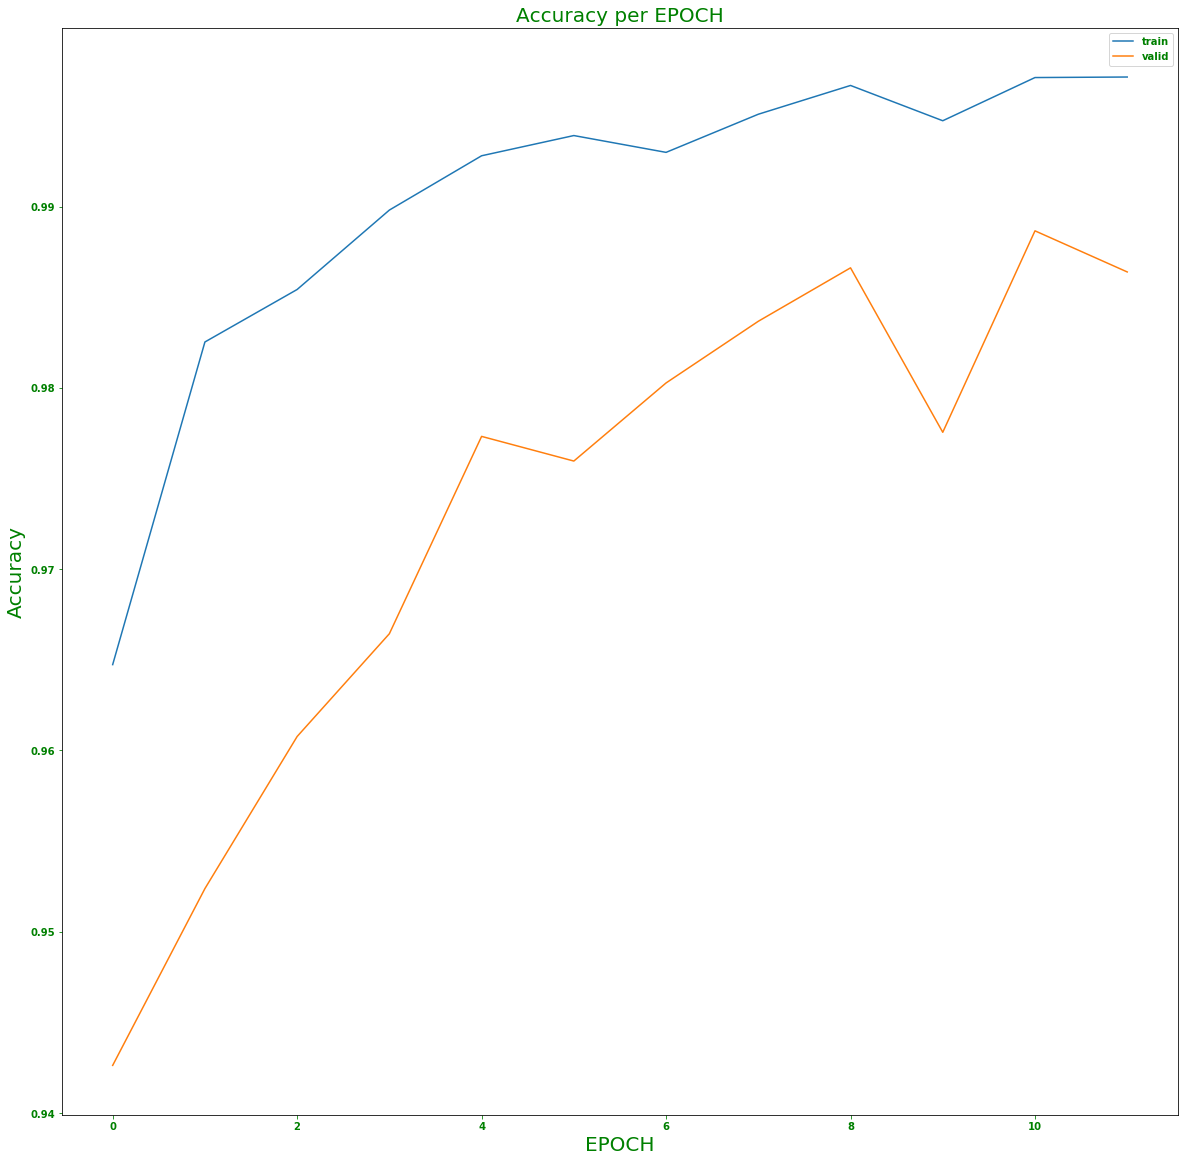

In [54]:
df_results = pd.DataFrame.from_dict(pd.read_pickle("accuracy.pkl"))
fig, ax = plt.subplots(figsize=(20,20))

ax = df_results.plot(ax=ax)
ax.tick_params(axis='y', colors='g')
ax.tick_params(axis='x', colors='g')
ax.set_title("Accuracy per EPOCH", color='g', fontsize=20)
ax.set_xlabel("EPOCH", color='g', fontsize=20)
ax.set_ylabel("Accuracy", color='g', fontsize=20)
plt.savefig("output_images/training_accuracy.png")

### Final accuracy for Validation and test

In [23]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./network.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    validation_accuracy = evaluate(sess, X_valid, y_valid, kp=1)
    print("EPOCH {} val acc {:.3f}".format(i+1, validation_accuracy))

    test_accuracy = evaluate(sess, X_test, y_test, kp=1)
    print("EPOCH {} test acc {:.3f}".format(i+1, test_accuracy))
    P = sess.run(probs, feed_dict={x: X_test, y: y_test, keep_prob: 1}) 
    P_web = sess.run(probs, feed_dict={x: X_web, y: y_web, keep_prob: 1}) 
    web_accuracy = evaluate(sess, X_web, y_web, kp=1)


INFO:tensorflow:Restoring parameters from ./network
EPOCH 12 val acc 0.986
EPOCH 12 test acc 0.971


In [24]:
# taken from https://stackoverflow.com/questions/26678467/export-a-pandas-dataframe-as-a-table-image
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


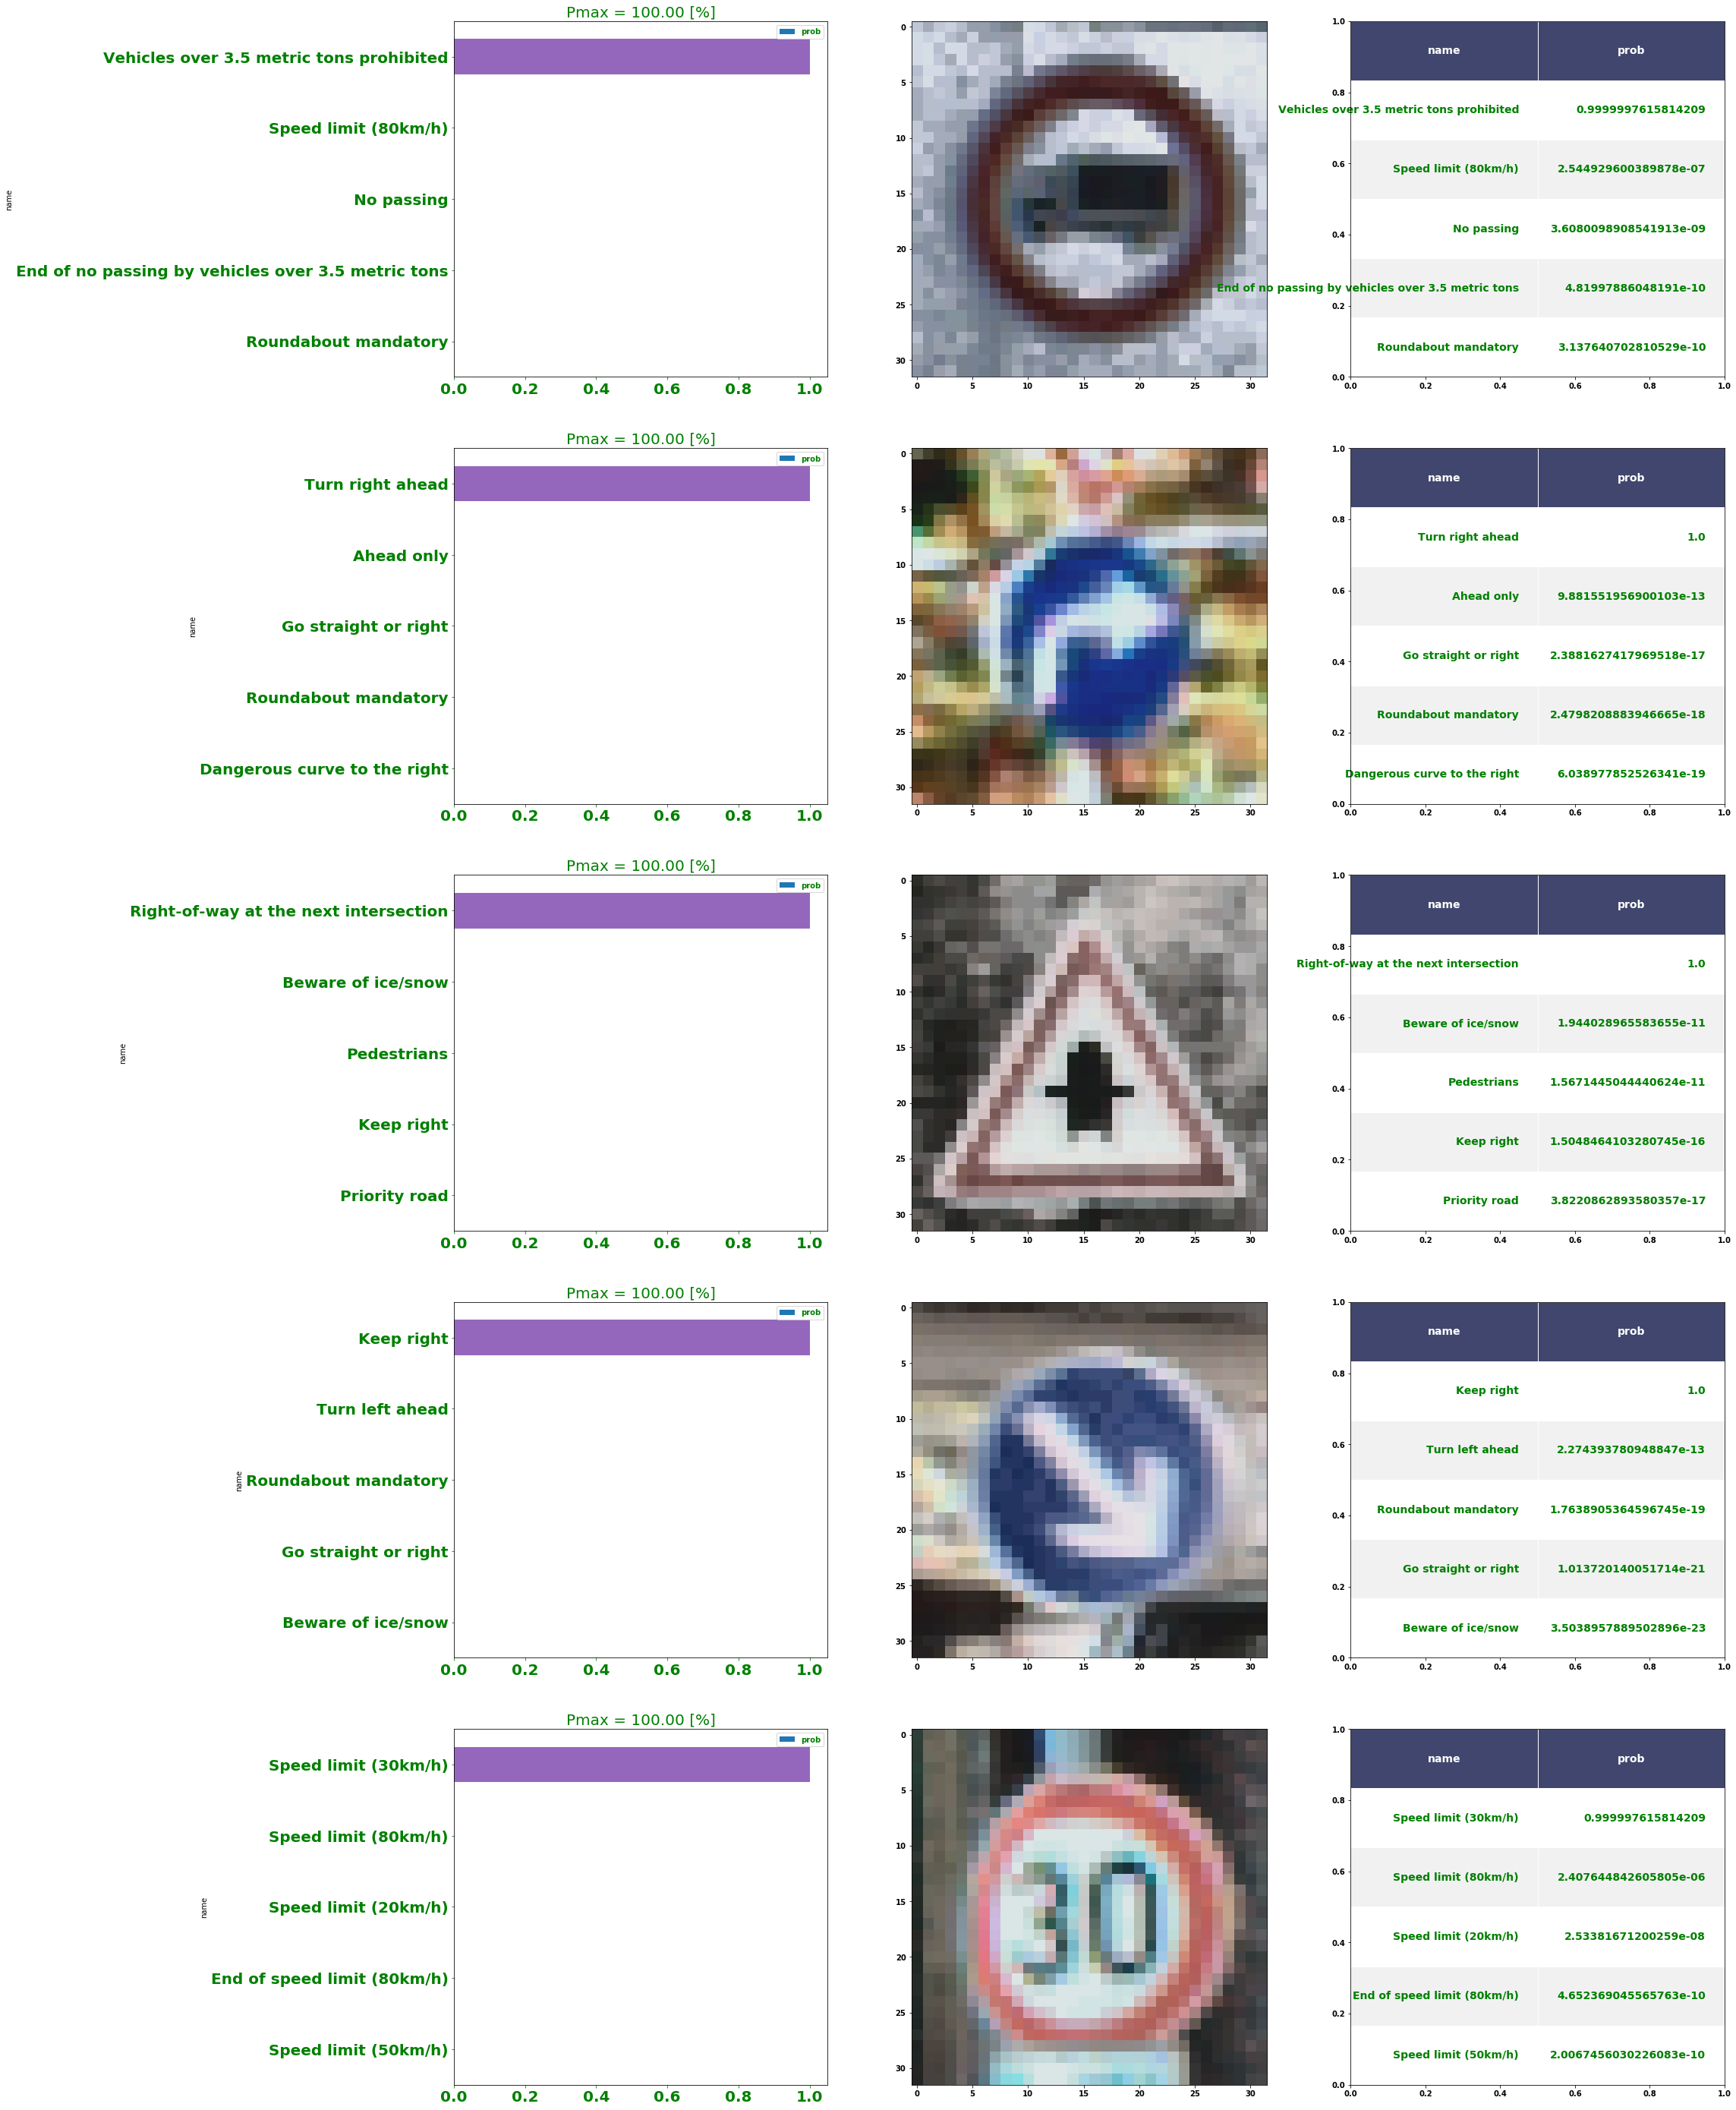

In [25]:
def show_top_5(probs, image, ax):
    p = pd.DataFrame(probs, columns=["prob"])
    p["name"] = list(map(lambda x: signnames.loc[x][0], range(len(probs))))
    p = p[["name", "prob"]]
    top5 = p.nlargest(5, "prob", keep="last")

    top5.iloc[::-1].plot.barh(x='name', y='prob', ax=ax[0], fontsize=20)
    ax[0].tick_params(axis='y', colors='g')
    ax[0].tick_params(axis='x', colors='g')
    ax[0].set_title("Pmax = %2.2f [%%]" % (100 * top5.prob.max()), fontsize=20)
    ax[1].imshow(image)
    
    ax[2] = render_mpl_table(top5, ax=ax[2])
    return ax

n = 10
nx = 3
ny = 5
fig, ax = utils.setup_figure(x_pics=nx, y_pics=ny, w=w, h=h, n=n, sharex=False, sharey=False)

visited = []
for isample in range(ny):
    j = np.random.randint(ny)
    while j in visited:
        j = np.random.randint(ny)
    visited.append(j)
    
    ax[isample] = show_top_5(P[j], X_test[j], ax[isample])


# plt.show()
fig.savefig('output_images/2_P5max_testset.png', bbox_inches='tight')


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

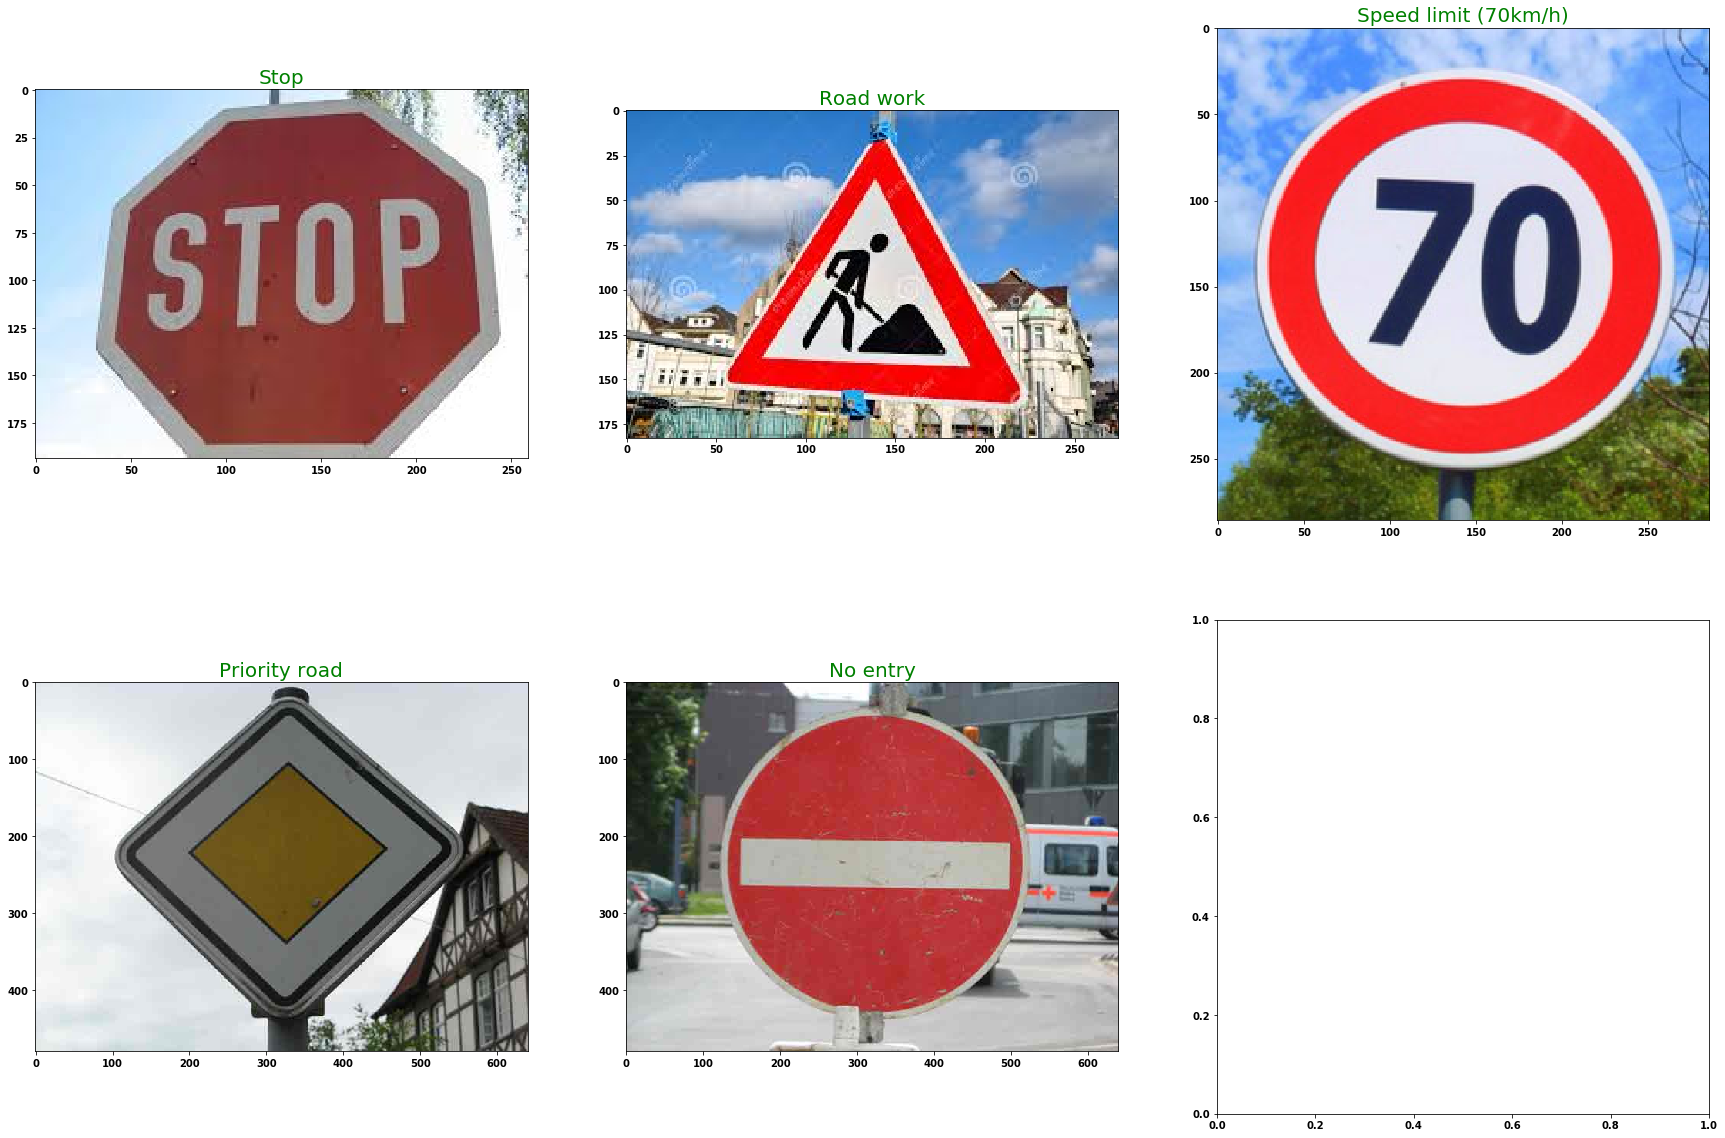

In [26]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

n = 10
nx = 3
ny = int(np.ceil(len(X_web_orig) / nx))

fig, ax = utils.setup_figure(x_pics=nx, y_pics=ny, w=w, h=h, n=n, sharex=False, sharey=False)
for i, x in enumerate(X_web_orig):
    ix = i % nx
    iy = int((i - ix) / nx)
    ax[iy][ix].imshow(X_web_orig[i], cmap='gray')
    ax[iy][ix].set_title(signnames.loc[y_web[i], "SignName"], fontsize=20, color='g')
                      


### Predict the Sign Type for Each Image

In [27]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./network.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    results = pd.DataFrame(columns=["image", "label", "predicted", "probability [%]"], index=range(len(P_web)))
    for iimage, index in enumerate(sess.run(tf.argmax(P_web, axis=1))):
        results.loc[iimage, "image"] = image_list[iimage]
        results.loc[iimage, "label"] = y_web[iimage]
        results.loc[iimage, "predicted"] = signnames.loc[index, "SignName"]
        results.loc[iimage, "probability [%]"] = 100*max(P_web[iimage])
        
results.to_html("output_images/3_P5max_webimages_probabilities.html")        
results

INFO:tensorflow:Restoring parameters from ./network


image label             predicted probability [%]
0           web_images/14_stop.jpg    14                  Stop         99.9375
1      web_images/25_road_work.jpg    25             Road work         94.6175
2           web_images/4_70mph.jpg     4  Speed limit (70km/h)             100
3  web_images/12_priority_road.jpg    12         Priority road             100
4      web_images/17_noentry_1.jpg    17              No entry         99.5942

### Analyze Performance

In [28]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
print("Web images accuracy {:.3f}".format(web_accuracy))


Web images accuracy 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [29]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

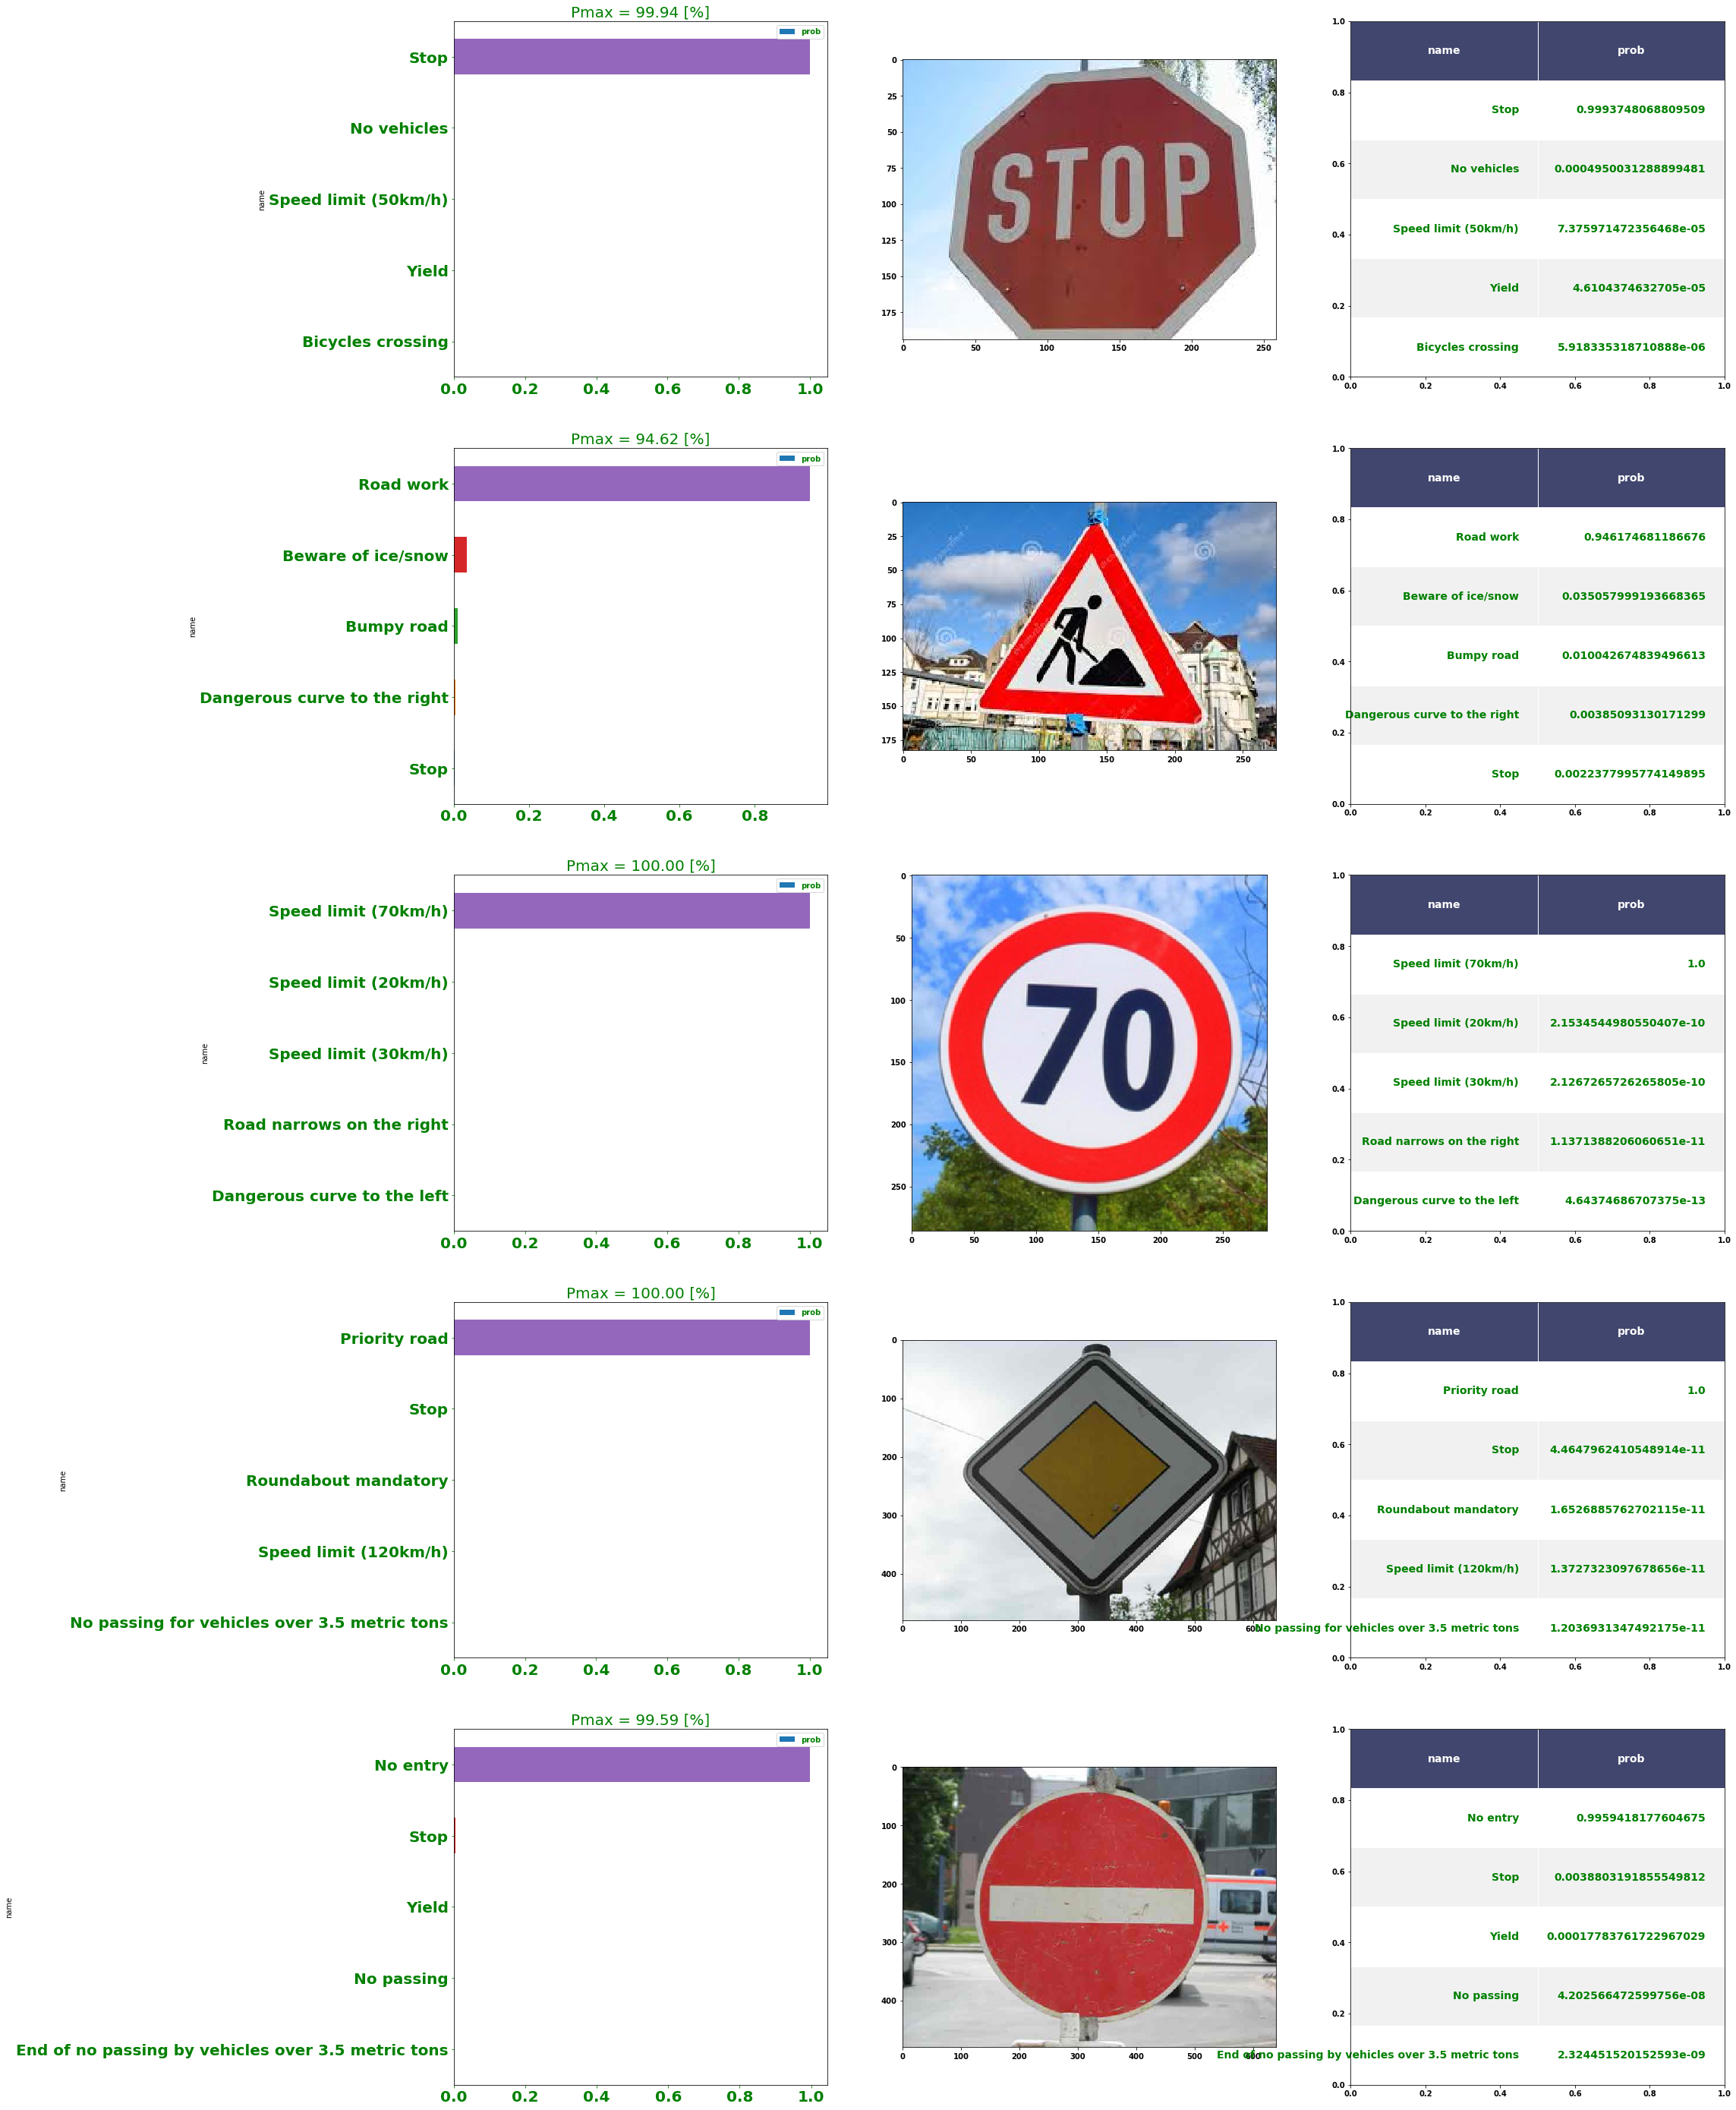

In [30]:
n = 10
nx = 3
ny = len(y_web)
fig, ax = utils.setup_figure(x_pics=nx, y_pics=ny, w=w, h=h, n=n, sharex=False, sharey=False)

for isample in range(ny):
    ax[isample] = show_top_5(P_web[isample], X_web_orig[isample], ax[isample])

fig.savefig('output_images/3_P5max_webset.png', bbox_inches='tight')


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [31]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

# References

[1]

[2] [enhance_contrast_of_color_image](https://chrisalbon.com/machine_learning/preprocessing_images/enhance_contrast_of_color_image/)

[3] [LeCun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

[4] [U-net](https://arxiv.org/pdf/1505.04597.pdf)